In [1]:
import pandas as pd
import numpy as np
import librosa 
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation, Embedding, SimpleRNN
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.models import load_model
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

2023-05-14 18:29:20.840779: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 18:29:24.414304: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
### Categorizing the ARPAbet phonemes into voiced, unvoiced and silence sets
# The total number of phonemes utilized is 62

voiced = ['aa', 'ae', 'ah', 'ao', 'aw', 'ax', 'axr', 'ay', 'eh', 'er', 'ey', 'ih', 'ix', 'iy', 'ow', 'oy', 'uh', 'uw', 'ux', 'b', 'd', 'dh', 'el', 'em', 'en', 'g', 'jh', 'l', 'm', 'n', 'ng', 'nx', 'r', 'v', 'w', 'wh', 'y', 'z', 'zh', 'eng', 'hv', 'bcl', 'dcl', 'gcl']
unvoiced = ['ch', 'dx', 'f', 'hh', 'k', 'p', 'q', 's', 'sh', 't', 'th', 'ax-h']
silence = ['kcl', 'pcl', 'tcl', 'pau', 'epi', 'h#']

In [30]:
### Dividing the dataset into train and validation sets
# The TIMIT dataset is divided into 8 dialect regions, each with 50 speakers.
# We will use 80% of the speakers for training and 20% for validation.
# The train and validation sets are saved in the lists train and val respectively.
# Each element of the list is the path to the speaker's folder.
 
timit_path = './timit_wav/'
dialects = os.listdir(timit_path+'train')
dialects = sorted(dialects)[1:]

train = []
val = []

for dialect in dialects:
    speakers = os.listdir(timit_path+'train/'+dialect)
    if '.DS_Store' in speakers: speakers.remove('.DS_Store')
    train_speakers = speakers[:int(len(speakers)*0.8)]
    val_speakers = speakers[int(len(speakers)*0.8):]
    for i in range(len(train_speakers)):
        train.append(timit_path+'train/'+dialect+'/'+train_speakers[i])
    for i in range(len(val_speakers)):
        val.append(timit_path+'train/'+dialect+'/'+val_speakers[i])

print(len(train), len(val))

366 96


In [31]:
### Reading in the test set
# The test set is stored in the list test.
# Each element of the list is the path to the speaker's folder.
# The test set is divided into 8 dialect regions, each with 24 speakers.

test = []

dialects_test = os.listdir(timit_path+'test')
dialects_test = sorted(dialects_test)
if '.DS_Store' in dialects_test: dialects_test.remove('.DS_Store')

for dialect in dialects_test:
    speakers = os.listdir(timit_path+'test/'+dialect)
    if '.DS_Store' in speakers: speakers.remove('.DS_Store')
    for i in range(len(speakers)):
        test.append(timit_path+'test/'+dialect+'/'+speakers[i])

In [51]:
### Extracting MFCCs and phonemes from the training set
# The MFCCs are extracted from the audio files and the corresponding phonemes are extracted from the phoneme files.
# The MFCCs and phonemes are stored in the dictionary mfcc_phn_train.
# The keys are the MFCCs and the values are the phonemes.
# The dictionary is converted to a dataframe and saved as a csv file.

mfcc_train = []
mfcc_phn_train = {}

for item in train:
    files = os.listdir(item)
    audiodata = []
    for file in sorted(files):
        if file == 'DS.Store': continue
        if file.endswith('.wav'):
            print('Processing === === === ', item, file)
            filename = file.split('.')[0]
            script = filename+'.phn'
            if script in files:
                with open(item+'/'+script, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        line = line.split(' ')
                        start = int(line[0])
                        end = int(line[1])
                        seq, Fs = librosa.load(item+'/'+file, sr=None)
                        # ignore warning
                        mfccs = librosa.feature.mfcc(y=seq[start:end], sr=Fs, n_mfcc=13).T
                        mfcc_train.append(mfccs)
                        phoneme = line[2].split('\n')[0]
                        for mfcc in mfccs:
                            mfcc_phn_train[tuple(mfcc)] = phoneme
                            
mfcc_phn_train = pd.DataFrame.from_dict(mfcc_phn_train, orient='index')
mfcc_phn_train = mfcc_phn_train.reset_index()
mfcc_phn_train.columns = ['mfcc', 'phoneme']
mfcc_phn_train = mfcc_phn_train.sort_values(by=['phoneme'])
mfcc_phn_train.to_csv('./mfcc_phn_train.csv', index=False)

Processing === === ===  ./timit_wav/train/dr1/ftbr0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1720
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=845
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1045
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1963
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=607
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/ftbr0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/ftbr0 si1402.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=487
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=976
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=797
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=190
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=776
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048

Processing === === ===  ./timit_wav/train/dr1/ftbr0 si2181.wav
Processing === === ===  ./timit_wav/train/dr1/ftbr0 si921.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1480
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=940
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1860
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1336
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1692
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/ftbr0 sx111.wav
Processing === === ===  ./timit_wav/train/dr1/ftbr0 sx201.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=510
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=840
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=459
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1227
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1597
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/ftbr0 sx21.wav
Processing === === ===  ./timit_wav/train/dr1/ftbr0 sx291.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=480
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1216
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=871
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=892
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=988
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr1/ftbr0 sx381.wav
Processing === === ===  ./timit_wav/train/dr1/fjsp0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1864
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1865
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=493
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=904
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=942
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/fjsp0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/fjsp0 si1434.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1890
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1627
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1128
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=925
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=974
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/fjsp0 si1763.wav
Processing === === ===  ./timit_wav/train/dr1/fjsp0 si804.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1430
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=475
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=627
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1081
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1180
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/fjsp0 sx174.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=235
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=712
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=631
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=826
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1286
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr1/fjsp0 sx264.wav
Processing === === ===  ./timit_wav/train/dr1/fjsp0 sx354.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1150
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=707
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=803
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1328
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1252
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/fjsp0 sx444.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=320
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1005
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=808
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=546
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1094
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/fjsp0 sx84.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=708
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=924
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1404
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1889
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=851
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/fsjk1 sa1.wav
Processing === === ===  ./timit_wav/train/dr1/fsjk1 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1057
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1660
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=622
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1815
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1500
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/fsjk1 si1025.wav
Processing === === ===  ./timit_wav/train/dr1/fsjk1 si2285.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=680
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=883
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1528
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=597
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1222
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/fsjk1 si696.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=967
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=822
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=939
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=484
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1276
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr1/fsjk1 sx125.wav
Processing === === ===  ./timit_wav/train/dr1/fsjk1 sx215.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1892
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1125
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=375
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=340
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2033
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/fsjk1 sx305.wav
Processing === === ===  ./timit_wav/train/dr1/fsjk1 sx35.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1457
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=283
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=620
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1431
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=306
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/fsjk1 sx395.wav
Processing === === ===  ./timit_wav/train/dr1/mtpf0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=705
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=735
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1906
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1144
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1115
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mtpf0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/mtpf0 si1235.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1516
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=604
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=542
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1778
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1271
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mtpf0 si1865.wav
Processing === === ===  ./timit_wav/train/dr1/mtpf0 si605.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=423
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=541
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1282
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=435
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=854
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr1/mtpf0 sx155.wav
Processing === === ===  ./timit_wav/train/dr1/mtpf0 sx245.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=666
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1334
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2037
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=240
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=626
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mtpf0 sx335.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=479
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1281
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=649
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1051
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1163
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mtpf0 sx425.wav
Processing === === ===  ./timit_wav/train/dr1/mtpf0 sx65.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=532
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1141
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1695
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1087
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=399
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/fvmh0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1378
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1321
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1237
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1324
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=316
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/fvmh0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=468
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=361
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1950
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=512
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=295
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr1/fvmh0 si1466.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=461
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1850
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=394
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=272
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1052
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/fvmh0 si2096.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1133
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1198
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1185
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1173
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1063
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft

Processing === === ===  ./timit_wav/train/dr1/fvmh0 si836.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=254
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=326
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=955
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1495
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=492
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr1/fvmh0 sx116.wav
Processing === === ===  ./timit_wav/train/dr1/fvmh0 sx206.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=805
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=661
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=912
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=758
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=850
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048

Processing === === ===  ./timit_wav/train/dr1/fvmh0 sx26.wav
Processing === === ===  ./timit_wav/train/dr1/fvmh0 sx296.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1503
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1443
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1591
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1560
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1121
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft

Processing === === ===  ./timit_wav/train/dr1/fvmh0 sx386.wav
Processing === === ===  ./timit_wav/train/dr1/mkls0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1046
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1032
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1507
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1062
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=728
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/mkls0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/mkls0 si1437.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1626
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1925
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1107
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=516
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1189
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/mkls0 si1533.wav
Processing === === ===  ./timit_wav/train/dr1/mkls0 si2067.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1389
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1751
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1701
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=986
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2034
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/mkls0 sx177.wav
Processing === === ===  ./timit_wav/train/dr1/mkls0 sx267.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1526
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1761
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1079
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1030
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2028
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft

Processing === === ===  ./timit_wav/train/dr1/mkls0 sx357.wav
Processing === === ===  ./timit_wav/train/dr1/mkls0 sx447.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1800
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1197
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1401
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=636
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=346
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mkls0 sx87.wav
Processing === === ===  ./timit_wav/train/dr1/mtrr0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=392
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=968
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=703
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1828
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1930
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mtrr0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/mtrr0 si1548.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1386
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1168
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1872
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1333
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=714
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/mtrr0 si2178.wav
Processing === === ===  ./timit_wav/train/dr1/mtrr0 si918.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1943
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=657
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=875
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1307
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1490
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mtrr0 sx108.wav
Processing === === ===  ./timit_wav/train/dr1/mtrr0 sx18.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=937
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=814
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1467
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1082
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1798
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mtrr0 sx198.wav
Processing === === ===  ./timit_wav/train/dr1/mtrr0 sx288.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=909
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1261
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1351
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=842
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1448
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mtrr0 sx378.wav
Processing === === ===  ./timit_wav/train/dr1/fdaw0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=577
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1117
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1092
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1749
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1435
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/fdaw0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/fdaw0 si1271.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=928
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1537
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=751
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1450
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=193
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/fdaw0 si1406.wav
Processing === === ===  ./timit_wav/train/dr1/fdaw0 si2036.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1305
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1776
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1738
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=692
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1027
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/fdaw0 sx146.wav
Processing === === ===  ./timit_wav/train/dr1/fdaw0 sx236.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1656
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1015
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1623
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1299
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=453
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/fdaw0 sx326.wav
Processing === === ===  ./timit_wav/train/dr1/fdaw0 sx416.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1841
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=225
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1268
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=749
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fdaw0 sx56.wav
Processing === === ===  ./timit_wav/train/dr1/mklw0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=576
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1866
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1486
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=333
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mklw0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/mklw0 si1571.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1914
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=709
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=314
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=965
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1017
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mklw0 si1844.wav
Processing === === ===  ./timit_wav/train/dr1/mklw0 si2201.wav
Processing === === ===  ./timit_wav/train/dr1/mklw0 sx131.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1501
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1148
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1456
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1732
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1476
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft

Processing === === ===  ./timit_wav/train/dr1/mklw0 sx221.wav
Processing === === ===  ./timit_wav/train/dr1/mklw0 sx311.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1533
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1753
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1802
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=455
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1917
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/mklw0 sx401.wav
Processing === === ===  ./timit_wav/train/dr1/mklw0 sx41.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=975
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=186
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=719
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=349
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=552
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048

Processing === === ===  ./timit_wav/train/dr1/mdac0 sa1.wav
Processing === === ===  ./timit_wav/train/dr1/mdac0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=538
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1878
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=441
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=999
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=161
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr1/mdac0 si1261.wav
Processing === === ===  ./timit_wav/train/dr1/mdac0 si1837.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=381
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=694
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1345
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=645
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=209
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr1/mdac0 si631.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=196
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1471
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=894
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=801
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1622
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mdac0 sx181.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1223
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=293
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=862
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=599
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1399
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mdac0 sx271.wav
Processing === === ===  ./timit_wav/train/dr1/mdac0 sx361.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1576
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1458
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=251
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1203
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1006
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mdac0 sx451.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1344
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1127
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1355
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=120
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=167
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mdac0 sx91.wav
Processing === === ===  ./timit_wav/train/dr1/mmgg0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=113
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=505
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=774
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=521
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=414
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048

Processing === === ===  ./timit_wav/train/dr1/mmgg0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/mmgg0 si1079.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1131
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=447
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1669
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1112
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1620
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/mmgg0 si1709.wav
Processing === === ===  ./timit_wav/train/dr1/mmgg0 si2339.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=356
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=748
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1782
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=229
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=772
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr1/mmgg0 sx179.wav
Processing === === ===  ./timit_wav/train/dr1/mmgg0 sx269.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1910
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=301
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1940
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1361
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=726
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mmgg0 sx359.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1758
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=325
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=436
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1353
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mmgg0 sx449.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=215
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=398
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=775
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1397
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=217
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr1/mmgg0 sx89.wav
Processing === === ===  ./timit_wav/train/dr1/fetb0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1716
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=918
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=489
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=514
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1493
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/fetb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/fetb0 si1148.wav
Processing === === ===  ./timit_wav/train/dr1/fetb0 si1778.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1301
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1567
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1737
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1875
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1181
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft

Processing === === ===  ./timit_wav/train/dr1/fetb0 si518.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=847
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2046
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1288
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=444
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fetb0 sx158.wav
Processing === === ===  ./timit_wav/train/dr1/fetb0 sx248.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1791
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=682
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1478
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=675
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1205
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/fetb0 sx338.wav
Processing === === ===  ./timit_wav/train/dr1/fetb0 sx428.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1164
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=406
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=351
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1257
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2002
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/fetb0 sx68.wav
Processing === === ===  ./timit_wav/train/dr1/mjwt0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=671
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1502
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=483
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=437
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1425
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mjwt0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/mjwt0 si1291.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=578
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1849
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1059
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1970
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=969
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mjwt0 si1381.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=656
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1757
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1575
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mjwt0 si751.wav
Processing === === ===  ./timit_wav/train/dr1/mjwt0 sx121.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1453
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1558
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=935
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=637
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1614
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mjwt0 sx211.wav
Processing === === ===  ./timit_wav/train/dr1/mjwt0 sx301.wav
Processing === === ===  ./timit_wav/train/dr1/mjwt0 sx31.wav
Processing === === ===  ./timit_wav/train/dr1/mjwt0 sx391.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1114
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=246
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1552
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1466
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1936
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fecd0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1038
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=893
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1352
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1877
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1886
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fecd0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/fecd0 si1418.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1830
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1460
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=476
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=128
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1098
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/fecd0 si2048.wav
Processing === === ===  ./timit_wav/train/dr1/fecd0 si788.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1444
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1618
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=562
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1832
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=888
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/fecd0 sx158.wav
Processing === === ===  ./timit_wav/train/dr1/fecd0 sx248.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1018
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1331
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1042
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=472
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1768
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/fecd0 sx338.wav
Processing === === ===  ./timit_wav/train/dr1/fecd0 sx428.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1184
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1919
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1475
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1075
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1134
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft

Processing === === ===  ./timit_wav/train/dr1/fecd0 sx68.wav
Processing === === ===  ./timit_wav/train/dr1/medr0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1335
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1804
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1831
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=291
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=508
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/medr0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/medr0 si1374.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1762
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=537
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1636
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=724
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=319
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/medr0 si2004.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2019
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=517
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=741
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=619
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=234
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/medr0 si744.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1967
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=408
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1447
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/medr0 sx114.wav
Processing === === ===  ./timit_wav/train/dr1/medr0 sx204.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1196
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1049
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1834
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1515
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/medr0 sx24.wav
Processing === === ===  ./timit_wav/train/dr1/medr0 sx294.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=271
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=231
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1657
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/medr0 sx384.wav
Processing === === ===  ./timit_wav/train/dr1/mtjs0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1939
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=201
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1851
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=281
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1318
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mtjs0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/mtjs0 si1192.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1246
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1154
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1298
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1884
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mtjs0 si1822.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=265
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=704
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=964
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1278
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=422
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr1/mtjs0 si562.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=768
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=601
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1383
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1016
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1039
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mtjs0 sx112.wav
Processing === === ===  ./timit_wav/train/dr1/mtjs0 sx202.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1869
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1903
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1255
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1304
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1953
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mtjs0 sx22.wav
Processing === === ===  ./timit_wav/train/dr1/mtjs0 sx292.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1406
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1142
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=241
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1553
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1322
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/mtjs0 sx382.wav
Processing === === ===  ./timit_wav/train/dr1/fmem0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1357
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=345
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1193
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1766
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=941
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/fmem0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/fmem0 si1377.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1433
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1329
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1264
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fmem0 si2007.wav
Processing === === ===  ./timit_wav/train/dr1/fmem0 si747.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1162
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1658
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1518
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1265
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1376
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft

Processing === === ===  ./timit_wav/train/dr1/fmem0 sx117.wav
Processing === === ===  ./timit_wav/train/dr1/fmem0 sx207.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1978
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=948
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=926
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=787
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=901
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr1/fmem0 sx297.wav
Processing === === ===  ./timit_wav/train/dr1/fmem0 sx333.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1836
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=908
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1582
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1105
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1535
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/fmem0 sx387.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1586
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=819
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=245
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=499
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fkfb0 sa1.wav
Processing === === ===  ./timit_wav/train/dr1/fkfb0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1428
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1876
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1578
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1955
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1711
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft

Processing === === ===  ./timit_wav/train/dr1/fkfb0 si1608.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=531
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1918
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1056
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fkfb0 si2238.wav
Processing === === ===  ./timit_wav/train/dr1/fkfb0 si978.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1809
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=180
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=179
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fkfb0 sx168.wav
Processing === === ===  ./timit_wav/train/dr1/fkfb0 sx258.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1489
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=644
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=163
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1874
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=697
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fkfb0 sx348.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=203
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=383
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1473
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1971
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fkfb0 sx438.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=371
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fkfb0 sx78.wav
Processing === === ===  ./timit_wav/train/dr1/mmrp0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1996
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1455
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1731
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1192
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1562
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft

Processing === === ===  ./timit_wav/train/dr1/mmrp0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/mmrp0 si2034.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=524
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1975
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=874
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1584
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mmrp0 si717.wav
Processing === === ===  ./timit_wav/train/dr1/mmrp0 si774.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1602
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1787
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=491
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=879
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1897
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mmrp0 sx144.wav
Processing === === ===  ./timit_wav/train/dr1/mmrp0 sx234.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=279
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1569
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1188
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=535
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=624
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mmrp0 sx324.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1233
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=742
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=778
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=387
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=653
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mmrp0 sx414.wav
Processing === === ===  ./timit_wav/train/dr1/mmrp0 sx54.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=518
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1742
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mrws0 sa1.wav
Processing === === ===  ./timit_wav/train/dr1/mrws0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1201
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1365
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mrws0 si1102.wav
Processing === === ===  ./timit_wav/train/dr1/mrws0 si1732.wav
Processing === === ===  ./timit_wav/train/dr1/mrws0 si472.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1596
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=127
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=727
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=181
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1659
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mrws0 sx112.wav
Processing === === ===  ./timit_wav/train/dr1/mrws0 sx202.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=504
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2038
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1633
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2041
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mrws0 sx22.wav
Processing === === ===  ./timit_wav/train/dr1/mrws0 sx292.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=192
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1862
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=611
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1927
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mrws0 sx382.wav
Processing === === ===  ./timit_wav/train/dr1/mrdd0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=169
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1846
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=855
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=917
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mrdd0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/mrdd0 si1050.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1442
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1464
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1767
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1479
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1968
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft

Processing === === ===  ./timit_wav/train/dr1/mrdd0 si1680.wav
Processing === === ===  ./timit_wav/train/dr1/mrdd0 si2310.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1837
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=765
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1833
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1393
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1364
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mrdd0 sx150.wav
Processing === === ===  ./timit_wav/train/dr1/mrdd0 sx240.wav
Processing === === ===  ./timit_wav/train/dr1/mrdd0 sx277.wav
Processing === === ===  ./timit_wav/train/dr1/mrdd0 sx330.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1338
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1441
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mrdd0 sx60.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1829
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=416
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mgrl0 sa1.wav
Processing === === ===  ./timit_wav/train/dr1/mgrl0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1461
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mgrl0 si1497.wav
Processing === === ===  ./timit_wav/train/dr1/mgrl0 si2127.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=595
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1496
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=343
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mgrl0 si867.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1921
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=485
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=811
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=465
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mgrl0 sx147.wav
Processing === === ===  ./timit_wav/train/dr1/mgrl0 sx237.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=287
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=98
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=189
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1548
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=998
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048

Processing === === ===  ./timit_wav/train/dr1/mgrl0 sx327.wav
Processing === === ===  ./timit_wav/train/dr1/mgrl0 sx417.wav
Processing === === ===  ./timit_wav/train/dr1/mgrl0 sx57.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1095
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=464
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=149
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=322
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1391
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mpsw0 sa1.wav
Processing === === ===  ./timit_wav/train/dr1/mpsw0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=439
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1605
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=691
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mpsw0 si1067.wav
Processing === === ===  ./timit_wav/train/dr1/mpsw0 si1697.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=176
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1808
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1673
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mpsw0 si2327.wav
Processing === === ===  ./timit_wav/train/dr1/mpsw0 sx167.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1292
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=317
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1157
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mpsw0 sx24.wav
Processing === === ===  ./timit_wav/train/dr1/mpsw0 sx257.wav
Processing === === ===  ./timit_wav/train/dr1/mpsw0 sx437.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1041
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1416
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1942
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=232
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=415
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mpsw0 sx77.wav
Processing === === ===  ./timit_wav/train/dr1/mrai0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=197
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1912
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=716
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1564
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mrai0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/mrai0 si1954.wav
Processing === === ===  ./timit_wav/train/dr1/mrai0 si2052.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1735
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1708
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1769
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mrai0 si792.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=841
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2023
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=963
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1933
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mrai0 sx162.wav
Processing === === ===  ./timit_wav/train/dr1/mrai0 sx252.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1126
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mrai0 sx342.wav
Processing === === ===  ./timit_wav/train/dr1/mrai0 sx432.wav
Processing === === ===  ./timit_wav/train/dr1/mrai0 sx72.wav
Processing === === ===  ./timit_wav/train/dr1/mrcg0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=152
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mrcg0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/mrcg0 si1428.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1539
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=411
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=515
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=264
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mrcg0 si2058.wav
Processing === === ===  ./timit_wav/train/dr1/mrcg0 si798.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=115
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1382
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1498
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1061
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1524
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mrcg0 sx168.wav
Processing === === ===  ./timit_wav/train/dr1/mrcg0 sx258.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=407
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=198
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=566
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mrcg0 sx348.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=221
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1941
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mrcg0 sx438.wav
Processing === === ===  ./timit_wav/train/dr1/mrcg0 sx78.wav
Processing === === ===  ./timit_wav/train/dr1/fcjf0 sa1.wav
Processing === === ===  ./timit_wav/train/dr1/fcjf0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/fcjf0 si1027.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=216
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=764
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fcjf0 si1657.wav
Processing === === ===  ./timit_wav/train/dr1/fcjf0 si648.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2011
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=166
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1788
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=328
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=498
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/fcjf0 sx127.wav
Processing === === ===  ./timit_wav/train/dr1/fcjf0 sx217.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1085
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=812
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1451
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fcjf0 sx307.wav
Processing === === ===  ./timit_wav/train/dr1/fcjf0 sx37.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1409
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=903
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=665
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=284
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1449
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/fcjf0 sx397.wav
Processing === === ===  ./timit_wav/train/dr1/fsah0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=363
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1726
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fsah0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/fsah0 si1244.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1311
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fsah0 si1874.wav
Processing === === ===  ./timit_wav/train/dr1/fsah0 si614.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=248
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1592
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fsah0 sx164.wav
Processing === === ===  ./timit_wav/train/dr1/fsah0 sx327.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1682
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=213
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=434
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=81
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fsah0 sx344.wav
Processing === === ===  ./timit_wav/train/dr1/fsah0 sx434.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1771
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fsah0 sx74.wav
Processing === === ===  ./timit_wav/train/dr1/fsma0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=177
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1817
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=259
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1577
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fsma0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/fsma0 si1621.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=897
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1902
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1598
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fsma0 si2251.wav
Processing === === ===  ./timit_wav/train/dr1/fsma0 si991.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1806
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1256
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1538
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=677
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fsma0 sx181.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1779
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fsma0 sx271.wav
Processing === === ===  ./timit_wav/train/dr1/fsma0 sx361.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=348
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1084
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=369
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=695
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1678
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/fsma0 sx451.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=412
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1531
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fsma0 sx91.wav
Processing === === ===  ./timit_wav/train/dr1/fvfb0 sa1.wav
Processing === === ===  ./timit_wav/train/dr1/fvfb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/fvfb0 si1032.wav
Processing === === ===  ./timit_wav/train/dr1/fvfb0 si1510.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1714
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fvfb0 si2292.wav
Processing === === ===  ./timit_wav/train/dr1/fvfb0 sx132.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1966
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=175
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fvfb0 sx222.wav
Processing === === ===  ./timit_wav/train/dr1/fvfb0 sx312.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=277
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=458
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=575
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/fvfb0 sx402.wav
Processing === === ===  ./timit_wav/train/dr1/fvfb0 sx42.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1811
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1423
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1204
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mdpk0 sa1.wav
Processing === === ===  ./timit_wav/train/dr1/mdpk0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/mdpk0 si1053.wav
Processing === === ===  ./timit_wav/train/dr1/mdpk0 si1683.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1068
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=255
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1484
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=206
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1129
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mdpk0 si552.wav
Processing === === ===  ./timit_wav/train/dr1/mdpk0 sx153.wav
Processing === === ===  ./timit_wav/train/dr1/mdpk0 sx243.wav
Processing === === ===  ./timit_wav/train/dr1/mdpk0 sx333.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=323
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=324
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=895
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mdpk0 sx423.wav
Processing === === ===  ./timit_wav/train/dr1/mdpk0 sx63.wav
Processing === === ===  ./timit_wav/train/dr2/mrfk0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1662
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrfk0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mrfk0 si1076.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1579
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1951
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=194
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrfk0 si1706.wav
Processing === === ===  ./timit_wav/train/dr2/mrfk0 si2336.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1718
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=89
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1773
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=696
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1104
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr2/mrfk0 sx176.wav
Processing === === ===  ./timit_wav/train/dr2/mrfk0 sx266.wav
Processing === === ===  ./timit_wav/train/dr2/mrfk0 sx356.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1789
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1704
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1544
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrfk0 sx446.wav
Processing === === ===  ./timit_wav/train/dr2/mrfk0 sx86.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1689
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=844
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=432
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrhl0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mrhl0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mrhl0 si1515.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=236
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1525
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrhl0 si2145.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=754
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1835
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrhl0 si885.wav
Processing === === ===  ./timit_wav/train/dr2/mrhl0 sx165.wav
Processing === === ===  ./timit_wav/train/dr2/mrhl0 sx255.wav
Processing === === ===  ./timit_wav/train/dr2/mrhl0 sx345.wav
Processing === === ===  ./timit_wav/train/dr2/mrhl0 sx435.wav
Processing === === ===  ./timit_wav/train/dr2/mrhl0 sx75.wav
Processing === === ===  ./timit_wav/train/dr2/fkaa0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1994
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fkaa0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/fkaa0 si1208.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=451
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1615
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1888
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fkaa0 si1838.wav
Processing === === ===  ./timit_wav/train/dr2/fkaa0 si578.wav
Processing === === ===  ./timit_wav/train/dr2/fkaa0 sx128.wav
Processing === === ===  ./timit_wav/train/dr2/fkaa0 sx218.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1709
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fkaa0 sx308.wav
Processing === === ===  ./timit_wav/train/dr2/fkaa0 sx38.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=509
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=357
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1508
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fkaa0 sx398.wav
Processing === === ===  ./timit_wav/train/dr2/fcmm0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2043
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fcmm0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/fcmm0 si1083.wav
Processing === === ===  ./timit_wav/train/dr2/fcmm0 si1957.wav
Processing === === ===  ./timit_wav/train/dr2/fcmm0 si453.wav
Processing === === ===  ./timit_wav/train/dr2/fcmm0 sx183.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=243
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=153
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=528
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fcmm0 sx273.wav
Processing === === ===  ./timit_wav/train/dr2/fcmm0 sx363.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1938
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fcmm0 sx420.wav
Processing === === ===  ./timit_wav/train/dr2/fcmm0 sx93.wav
Processing === === ===  ./timit_wav/train/dr2/mmxs0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1653
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1997
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1823
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1786
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=141
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mmxs0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mmxs0 si2136.wav
Processing === === ===  ./timit_wav/train/dr2/mmxs0 si629.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1974
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mmxs0 si876.wav
Processing === === ===  ./timit_wav/train/dr2/mmxs0 sx156.wav
Processing === === ===  ./timit_wav/train/dr2/mmxs0 sx246.wav
Processing === === ===  ./timit_wav/train/dr2/mmxs0 sx336.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=296
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=473
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=191
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1812
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mmxs0 sx426.wav
Processing === === ===  ./timit_wav/train/dr2/mmxs0 sx66.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1693
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mtbc0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1883
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mtbc0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mtbc0 si1173.wav
Processing === === ===  ./timit_wav/train/dr2/mtbc0 si1803.wav
Processing === === ===  ./timit_wav/train/dr2/mtbc0 si543.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1946
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=391
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mtbc0 sx183.wav
Processing === === ===  ./timit_wav/train/dr2/mtbc0 sx273.wav
Processing === === ===  ./timit_wav/train/dr2/mtbc0 sx347.wav
Processing === === ===  ./timit_wav/train/dr2/mtbc0 sx363.wav
Processing === === ===  ./timit_wav/train/dr2/mtbc0 sx93.wav
Processing === === ===  ./timit_wav/train/dr2/fmkf0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/fmkf0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/fmkf0 si1018.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1741
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1179
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fmkf0 si1536.wav
Processing === === ===  ./timit_wav/train/dr2/fmkf0 si906.wav
Processing === === ===  ./timit_wav/train/dr2/fmkf0 sx186.wav
Processing === === ===  ./timit_wav/train/dr2/fmkf0 sx276.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=109
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fmkf0 sx366.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=388
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1342
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fmkf0 sx6.wav
Processing === === ===  ./timit_wav/train/dr2/fmkf0 sx96.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1981
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1684
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mdem0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mdem0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mdem0 si1868.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=294
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=298
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mdem0 si608.wav
Processing === === ===  ./timit_wav/train/dr2/mdem0 si800.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1986
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=421
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mdem0 sx158.wav
Processing === === ===  ./timit_wav/train/dr2/mdem0 sx248.wav
Processing === === ===  ./timit_wav/train/dr2/mdem0 sx338.wav
Processing === === ===  ./timit_wav/train/dr2/mdem0 sx428.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=274
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=364
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mdem0 sx68.wav
Processing === === ===  ./timit_wav/train/dr2/mtat1 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=382
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mtat1 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mtat1 si1409.wav
Processing === === ===  ./timit_wav/train/dr2/mtat1 si1627.wav
Processing === === ===  ./timit_wav/train/dr2/mtat1 si779.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1775
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mtat1 sx149.wav
Processing === === ===  ./timit_wav/train/dr2/mtat1 sx239.wav
Processing === === ===  ./timit_wav/train/dr2/mtat1 sx329.wav
Processing === === ===  ./timit_wav/train/dr2/mtat1 sx419.wav
Processing === === ===  ./timit_wav/train/dr2/mtat1 sx59.wav
Processing === === ===  ./timit_wav/train/dr2/flmc0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/flmc0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1885
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2035
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/flmc0 si1372.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1923
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1792
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2045
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/flmc0 si2002.wav
Processing === === ===  ./timit_wav/train/dr2/flmc0 si742.wav
Processing === === ===  ./timit_wav/train/dr2/flmc0 sx112.wav
Processing === === ===  ./timit_wav/train/dr2/flmc0 sx22.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=338
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=342
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1202
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/flmc0 sx292.wav
Processing === === ===  ./timit_wav/train/dr2/flmc0 sx336.wav
Processing === === ===  ./timit_wav/train/dr2/flmc0 sx382.wav
Processing === === ===  ./timit_wav/train/dr2/mkah0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mkah0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mkah0 si1528.wav
Processing === === ===  ./timit_wav/train/dr2/mkah0 si2158.wav
Processing === === ===  ./timit_wav/train/dr2/mkah0 si898.wav
Processing === === ===  ./timit_wav/train/dr2/mkah0 sx178.wav
Processing === === ===  ./timit_wav/train/dr2/mkah0 sx268.wav
Processing === === ===  ./timit_wav/train/dr2/mkah0 sx358.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1483
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mkah0 sx448.wav
Processing === === ===  ./timit_wav/train/dr2/mkah0 sx88.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1374
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2022
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrjm0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mrjm0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mrjm0 si1095.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1595
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1932
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrjm0 si1228.wav
Processing === === ===  ./timit_wav/train/dr2/mrjm0 si1858.wav
Processing === === ===  ./timit_wav/train/dr2/mrjm0 sx148.wav
Processing === === ===  ./timit_wav/train/dr2/mrjm0 sx238.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1952
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrjm0 sx328.wav
Processing === === ===  ./timit_wav/train/dr2/mrjm0 sx418.wav
Processing === === ===  ./timit_wav/train/dr2/mrjm0 sx58.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1652
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1663
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fdxw0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/fdxw0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1419
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fdxw0 si1511.wav
Processing === === ===  ./timit_wav/train/dr2/fdxw0 si2141.wav
Processing === === ===  ./timit_wav/train/dr2/fdxw0 si881.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=154
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1613
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fdxw0 sx161.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1384
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fdxw0 sx251.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=299
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fdxw0 sx341.wav
Processing === === ===  ./timit_wav/train/dr2/fdxw0 sx431.wav
Processing === === ===  ./timit_wav/train/dr2/fdxw0 sx71.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2021
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mmaa0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mmaa0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mmaa0 si1588.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1989
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=337
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mmaa0 si2105.wav
Processing === === ===  ./timit_wav/train/dr2/mmaa0 si845.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=222
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1407
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mmaa0 sx125.wav
Processing === === ===  ./timit_wav/train/dr2/mmaa0 sx215.wav
Processing === === ===  ./timit_wav/train/dr2/mmaa0 sx305.wav
Processing === === ===  ./timit_wav/train/dr2/mmaa0 sx35.wav
Processing === === ===  ./timit_wav/train/dr2/mmaa0 sx395.wav
Processing === === ===  ./timit_wav/train/dr2/mcew0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mcew0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mcew0 si1442.wav
Processing === === ===  ./timit_wav/train/dr2/mcew0 si2072.wav
Processing === === ===  ./timit_wav/train/dr2/mcew0 si812.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1608
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=147
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1717
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mcew0 sx182.wav
Processing === === ===  ./timit_wav/train/dr2/mcew0 sx272.wav
Processing === === ===  ./timit_wav/train/dr2/mcew0 sx362.wav
Processing === === ===  ./timit_wav/train/dr2/mcew0 sx452.wav
Processing === === ===  ./timit_wav/train/dr2/mcew0 sx92.wav
Processing === === ===  ./timit_wav/train/dr2/feac0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1904
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/feac0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/feac0 si1245.wav
Processing === === ===  ./timit_wav/train/dr2/feac0 si1875.wav
Processing === === ===  ./timit_wav/train/dr2/feac0 si615.wav
Processing === === ===  ./timit_wav/train/dr2/feac0 sx165.wav
Processing === === ===  ./timit_wav/train/dr2/feac0 sx255.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=202
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1852
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1827
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/feac0 sx345.wav
Processing === === ===  ./timit_wav/train/dr2/feac0 sx435.wav
Processing === === ===  ./timit_wav/train/dr2/feac0 sx75.wav
Processing === === ===  ./timit_wav/train/dr2/fsrh0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1723
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1931
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=171
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fsrh0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/fsrh0 si1719.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1651
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1625
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fsrh0 si1931.wav
Processing === === ===  ./timit_wav/train/dr2/fsrh0 si671.wav
Processing === === ===  ./timit_wav/train/dr2/fsrh0 sx131.wav
Processing === === ===  ./timit_wav/train/dr2/fsrh0 sx221.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1319
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=165
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fsrh0 sx311.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1965
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fsrh0 sx401.wav
Processing === === ===  ./timit_wav/train/dr2/fsrh0 sx41.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=393
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mtjg0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mtjg0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mtjg0 si1520.wav
Processing === === ===  ./timit_wav/train/dr2/mtjg0 si2157.wav
Processing === === ===  ./timit_wav/train/dr2/mtjg0 si890.wav
Processing === === ===  ./timit_wav/train/dr2/mtjg0 sx170.wav
Processing === === ===  ./timit_wav/train/dr2/mtjg0 sx260.wav
Processing === === ===  ./timit_wav/train/dr2/mtjg0 sx350.wav
Processing === === ===  ./timit_wav/train/dr2/mtjg0 sx440.wav
Processing === === ===  ./timit_wav/train/dr2/mtjg0 sx80.wav
Processing === === ===  ./timit_wav/train/dr2/mmds0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mmds0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mmds0 si1343.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1793
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mmds0 si1973.wav
Processing === === ===  ./timit_wav/train/dr2/mmds0 si713.wav
Processing === === ===  ./timit_wav/train/dr2/mmds0 sx173.wav
Processing === === ===  ./timit_wav/train/dr2/mmds0 sx263.wav
Processing === === ===  ./timit_wav/train/dr2/mmds0 sx353.wav
Processing === === ===  ./timit_wav/train/dr2/mmds0 sx443.wav
Processing === === ===  ./timit_wav/train/dr2/mmds0 sx83.wav
Processing === === ===  ./timit_wav/train/dr2/mtdb0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mtdb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mtdb0 si1401.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=329
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mtdb0 si2031.wav
Processing === === ===  ./timit_wav/train/dr2/mtdb0 si771.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2009
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mtdb0 sx141.wav
Processing === === ===  ./timit_wav/train/dr2/mtdb0 sx231.wav
Processing === === ===  ./timit_wav/train/dr2/mtdb0 sx321.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=110
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=219
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mtdb0 sx411.wav
Processing === === ===  ./timit_wav/train/dr2/mtdb0 sx51.wav
Processing === === ===  ./timit_wav/train/dr2/mrjm1 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mrjm1 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mrjm1 si1298.wav
Processing === === ===  ./timit_wav/train/dr2/mrjm1 si1928.wav
Processing === === ===  ./timit_wav/train/dr2/mrjm1 si668.wav
Processing === === ===  ./timit_wav/train/dr2/mrjm1 sx128.wav
Processing === === ===  ./timit_wav/train/dr2/mrjm1 sx218.wav
Processing === === ===  ./timit_wav/train/dr2/mrjm1 sx308.wav
Processing === === ===  ./timit_wav/train/dr2/mrjm1 sx38.wav
Processing === === ===  ./timit_wav/train/dr2/mrjm1 sx398.wav
Processing === === ===  ./timit_wav/train/dr2/msat0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/msat0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/msat0 si1526.wav
Processing === === ===  ./timit_wav/train/dr2/msat0 si2156.wav
Processing ===

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1945
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mctm0 sx450.wav
Processing === === ===  ./timit_wav/train/dr2/mctm0 sx90.wav
Processing === === ===  ./timit_wav/train/dr2/mkdt0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mkdt0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mkdt0 si2153.wav
Processing === === ===  ./timit_wav/train/dr2/mkdt0 si814.wav
Processing === === ===  ./timit_wav/train/dr2/mkdt0 si893.wav
Processing === === ===  ./timit_wav/train/dr2/mkdt0 sx173.wav
Processing === === ===  ./timit_wav/train/dr2/mkdt0 sx263.wav
Processing === === ===  ./timit_wav/train/dr2/mkdt0 sx353.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1795
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mkdt0 sx443.wav
Processing === === ===  ./timit_wav/train/dr2/mkdt0 sx83.wav
Processing === === ===  ./timit_wav/train/dr2/fcaj0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/fcaj0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/fcaj0 si1479.wav
Processing === === ===  ./timit_wav/train/dr2/fcaj0 si1804.wav
Processing === === ===  ./timit_wav/train/dr2/fcaj0 si849.wav
Processing === === ===  ./timit_wav/train/dr2/fcaj0 sx129.wav
Processing === === ===  ./timit_wav/train/dr2/fcaj0 sx219.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1944
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fcaj0 sx309.wav
Processing === === ===  ./timit_wav/train/dr2/fcaj0 sx39.wav
Processing === === ===  ./timit_wav/train/dr2/fcaj0 sx399.wav
Processing === === ===  ./timit_wav/train/dr2/mjbg0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mjbg0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mjbg0 si1232.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1752
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mjbg0 si1724.wav
Processing === === ===  ./timit_wav/train/dr2/mjbg0 si1862.wav
Processing === === ===  ./timit_wav/train/dr2/mjbg0 sx152.wav
Processing === === ===  ./timit_wav/train/dr2/mjbg0 sx242.wav
Processing === === ===  ./timit_wav/train/dr2/mjbg0 sx332.wav
Processing === === ===  ./timit_wav/train/dr2/mjbg0 sx422.wav
Processing === === ===  ./timit_wav/train/dr2/mjbg0 sx62.wav
Processing === === ===  ./timit_wav/train/dr2/mzmb0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mzmb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mzmb0 si1166.wav
Processing === === ===  ./timit_wav/train/dr2/mzmb0 si1796.wav
Processing === === ===  ./timit_wav/train/dr2/mzmb0 si536.wav
Processing === === ===  ./timit_wav/train/dr2/mzmb0 sx176.wav
Processing === === ===  ./timit_wav/train/dr2/mzmb0 sx266.wav
Processing === === ===  ./timit_wav/train/dr2/mzmb0 sx356.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1845
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mzmb0 sx446.wav
Processing === === ===  ./timit_wav/train/dr2/mzmb0 sx86.wav
Processing === === ===  ./timit_wav/train/dr2/marc0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/marc0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/marc0 si1188.wav
Processing === === ===  ./timit_wav/train/dr2/marc0 si1818.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=172
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1899
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/marc0 si558.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=125
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=162
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=145
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/marc0 sx108.wav
Processing === === ===  ./timit_wav/train/dr2/marc0 sx18.wav
Processing === === ===  ./timit_wav/train/dr2/marc0 sx198.wav
Processing === === ===  ./timit_wav/train/dr2/marc0 sx288.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=75
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=208
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/marc0 sx378.wav
Processing === === ===  ./timit_wav/train/dr2/fajw0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/fajw0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/fajw0 si1263.wav
Processing === === ===  ./timit_wav/train/dr2/fajw0 si1893.wav
Processing === === ===  ./timit_wav/train/dr2/fajw0 si633.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=228
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=297
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fajw0 sx183.wav
Processing === === ===  ./timit_wav/train/dr2/fajw0 sx273.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1634
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fajw0 sx3.wav
Processing === === ===  ./timit_wav/train/dr2/fajw0 sx363.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=318
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fajw0 sx93.wav
Processing === === ===  ./timit_wav/train/dr2/mrlr0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mrlr0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mrlr0 si1196.wav
Processing === === ===  ./timit_wav/train/dr2/mrlr0 si1826.wav
Processing === === ===  ./timit_wav/train/dr2/mrlr0 si566.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1993
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrlr0 sx116.wav
Processing === === ===  ./timit_wav/train/dr2/mrlr0 sx206.wav
Processing === === ===  ./timit_wav/train/dr2/mrlr0 sx26.wav
Processing === === ===  ./timit_wav/train/dr2/mrlr0 sx296.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=182
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2036
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrlr0 sx386.wav
Processing === === ===  ./timit_wav/train/dr2/mjae0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=129
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=183
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mjae0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mjae0 si1524.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2031
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mjae0 si1999.wav
Processing === === ===  ./timit_wav/train/dr2/mjae0 si2154.wav
Processing === === ===  ./timit_wav/train/dr2/mjae0 sx174.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1303
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mjae0 sx264.wav
Processing === === ===  ./timit_wav/train/dr2/mjae0 sx354.wav
Processing === === ===  ./timit_wav/train/dr2/mjae0 sx444.wav
Processing === === ===  ./timit_wav/train/dr2/mjae0 sx84.wav
Processing === === ===  ./timit_wav/train/dr2/fpjf0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/fpjf0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/fpjf0 si1046.wav
Processing === === ===  ./timit_wav/train/dr2/fpjf0 si1259.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=131
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fpjf0 si1676.wav
Processing === === ===  ./timit_wav/train/dr2/fpjf0 sx146.wav
Processing === === ===  ./timit_wav/train/dr2/fpjf0 sx236.wav
Processing === === ===  ./timit_wav/train/dr2/fpjf0 sx326.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=187
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fpjf0 sx352.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=143
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=247
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fpjf0 sx56.wav
Processing === === ===  ./timit_wav/train/dr2/mjma0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mjma0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mjma0 si1495.wav
Processing === === ===  ./timit_wav/train/dr2/mjma0 si2125.wav
Processing === === ===  ./timit_wav/train/dr2/mjma0 si865.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=144
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mjma0 sx145.wav
Processing === === ===  ./timit_wav/train/dr2/mjma0 sx235.wav
Processing === === ===  ./timit_wav/train/dr2/mjma0 sx325.wav
Processing === === ===  ./timit_wav/train/dr2/mjma0 sx415.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=155
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mjma0 sx55.wav
Processing === === ===  ./timit_wav/train/dr2/mdwd0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mdwd0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mdwd0 si1260.wav
Processing === === ===  ./timit_wav/train/dr2/mdwd0 si1890.wav
Processing === === ===  ./timit_wav/train/dr2/mdwd0 si557.wav
Processing === === ===  ./timit_wav/train/dr2/mdwd0 sx180.wav
Processing === === ===  ./timit_wav/train/dr2/mdwd0 sx270.wav
Processing === === ===  ./timit_wav/train/dr2/mdwd0 sx360.wav
Processing === === ===  ./timit_wav/train/dr2/mdwd0 sx450.wav
Processing === === ===  ./timit_wav/train/dr2/mdwd0 sx90.wav
Processing === === ===  ./timit_wav/train/dr2/mhrm0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mhrm0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mhrm0 si1475.wav
Processing === === ===  ./timit_wav/train/dr2/mhrm0 si2218.wav
Processing === === ===  ./timit_wav/train/dr2/mhrm0 si958.wav
Processing ===

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1842
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1561
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mjde0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mjde0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mjde0 si1120.wav
Processing === === ===  ./timit_wav/train/dr2/mjde0 si463.wav
Processing === === ===  ./timit_wav/train/dr2/mjde0 si490.wav
Processing === === ===  ./timit_wav/train/dr2/mjde0 sx130.wav
Processing === === ===  ./timit_wav/train/dr2/mjde0 sx220.wav
Processing === === ===  ./timit_wav/train/dr2/mjde0 sx310.wav
Processing === === ===  ./timit_wav/train/dr2/mjde0 sx40.wav
Processing === === ===  ./timit_wav/train/dr2/mjde0 sx400.wav
Processing === === ===  ./timit_wav/train/dr2/mjeb0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mjeb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mjeb0 si1286.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1969
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mjeb0 si1916.wav
Processing === === ===  ./timit_wav/train/dr2/mjeb0 si656.wav
Processing === === ===  ./timit_wav/train/dr2/mjeb0 sx170.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1913
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mjeb0 sx206.wav
Processing === === ===  ./timit_wav/train/dr2/mjeb0 sx26.wav
Processing === === ===  ./timit_wav/train/dr2/mjeb0 sx296.wav
Processing === === ===  ./timit_wav/train/dr2/mjeb0 sx386.wav
Processing === === ===  ./timit_wav/train/dr2/mkjo0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mkjo0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mkjo0 si1517.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=258
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mkjo0 si2147.wav
Processing === === ===  ./timit_wav/train/dr2/mkjo0 si887.wav
Processing === === ===  ./timit_wav/train/dr2/mkjo0 sx167.wav
Processing === === ===  ./timit_wav/train/dr2/mkjo0 sx257.wav
Processing === === ===  ./timit_wav/train/dr2/mkjo0 sx424.wav
Processing === === ===  ./timit_wav/train/dr2/mkjo0 sx437.wav
Processing === === ===  ./timit_wav/train/dr2/mkjo0 sx77.wav
Processing === === ===  ./timit_wav/train/dr2/mdbp0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mdbp0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mdbp0 si1158.wav
Processing === === ===  ./timit_wav/train/dr2/mdbp0 si1788.wav
Processing === === ===  ./timit_wav/train/dr2/mdbp0 si528.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1674
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1979
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mdbp0 sx168.wav
Processing === === ===  ./timit_wav/train/dr2/mdbp0 sx258.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1855
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=214
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mdbp0 sx348.wav
Processing === === ===  ./timit_wav/train/dr2/mdbp0 sx438.wav
Processing === === ===  ./timit_wav/train/dr2/mdbp0 sx78.wav
Processing === === ===  ./timit_wav/train/dr2/fscn0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/fscn0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/fscn0 si1886.wav
Processing === === ===  ./timit_wav/train/dr2/fscn0 si626.wav
Processing === === ===  ./timit_wav/train/dr2/fscn0 si705.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1557
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fscn0 sx176.wav
Processing === === ===  ./timit_wav/train/dr2/fscn0 sx266.wav
Processing === === ===  ./timit_wav/train/dr2/fscn0 sx356.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=312
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fscn0 sx446.wav
Processing === === ===  ./timit_wav/train/dr2/fscn0 sx86.wav
Processing === === ===  ./timit_wav/train/dr2/mdlb0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mdlb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mdlb0 si1306.wav
Processing === === ===  ./timit_wav/train/dr2/mdlb0 si1936.wav
Processing === === ===  ./timit_wav/train/dr2/mdlb0 si676.wav
Processing === === ===  ./timit_wav/train/dr2/mdlb0 sx136.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1551
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mdlb0 sx226.wav
Processing === === ===  ./timit_wav/train/dr2/mdlb0 sx316.wav
Processing === === ===  ./timit_wav/train/dr2/mdlb0 sx406.wav
Processing === === ===  ./timit_wav/train/dr2/mdlb0 sx46.wav
Processing === === ===  ./timit_wav/train/dr2/mprb0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mprb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mprb0 si1205.wav
Processing === === ===  ./timit_wav/train/dr2/mprb0 si1215.wav
Processing === === ===  ./timit_wav/train/dr2/mprb0 si575.wav
Processing === === ===  ./timit_wav/train/dr2/mprb0 sx125.wav
Processing === === ===  ./timit_wav/train/dr2/mprb0 sx215.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1777
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mprb0 sx305.wav
Processing === === ===  ./timit_wav/train/dr2/mprb0 sx35.wav
Processing === === ===  ./timit_wav/train/dr2/mprb0 sx395.wav
Processing === === ===  ./timit_wav/train/dr2/flma0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/flma0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/flma0 si1243.wav
Processing === === ===  ./timit_wav/train/dr2/flma0 si1873.wav
Processing === === ===  ./timit_wav/train/dr2/flma0 si613.wav
Processing === === ===  ./timit_wav/train/dr2/flma0 sx163.wav
Processing === === ===  ./timit_wav/train/dr2/flma0 sx253.wav
Processing === === ===  ./timit_wav/train/dr2/flma0 sx343.wav
Processing === === ===  ./timit_wav/train/dr2/flma0 sx433.wav
Processing === === ===  ./timit_wav/train/dr2/flma0 sx73.wav
Processing === === ===  ./timit_wav/train/dr2/fmmh0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/fmmh0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/fmmh0 si1537.wav
Processing === 

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1694
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mwsb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mwsb0 si1626.wav
Processing === === ===  ./timit_wav/train/dr2/mwsb0 si2256.wav
Processing === === ===  ./timit_wav/train/dr2/mwsb0 si996.wav
Processing === === ===  ./timit_wav/train/dr2/mwsb0 sx186.wav
Processing === === ===  ./timit_wav/train/dr2/mwsb0 sx276.wav
Processing === === ===  ./timit_wav/train/dr2/mwsb0 sx366.wav
Processing === === ===  ./timit_wav/train/dr2/mwsb0 sx6.wav
Processing === === ===  ./timit_wav/train/dr2/mwsb0 sx96.wav
Processing === === ===  ./timit_wav/train/dr2/mbjv0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mbjv0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mbjv0 si1247.wav
Processing === === ===  ./timit_wav/train/dr2/mbjv0 si1877.wav
Processing === === ===  ./timit_wav/train/dr2/mbjv0 si617.wav
Processing === === ===  ./timit_wav/train/dr2/mbjv0 sx167.wav
Processing === === ===  ./timit_wav/train/dr2/mbjv0 sx257.wav
Processing ==

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1868
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mjhi0 si1328.wav
Processing === === ===  ./timit_wav/train/dr2/mjhi0 si555.wav
Processing === === ===  ./timit_wav/train/dr2/mjhi0 si698.wav
Processing === === ===  ./timit_wav/train/dr2/mjhi0 sx158.wav
Processing === === ===  ./timit_wav/train/dr2/mjhi0 sx248.wav
Processing === === ===  ./timit_wav/train/dr2/mjhi0 sx338.wav
Processing === === ===  ./timit_wav/train/dr2/mjhi0 sx428.wav
Processing === === ===  ./timit_wav/train/dr2/mjhi0 sx68.wav
Processing === === ===  ./timit_wav/train/dr2/mdlc2 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=157
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mdlc2 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mdlc2 si1614.wav
Processing === === ===  ./timit_wav/train/dr2/mdlc2 si2244.wav
Processing === === ===  ./timit_wav/train/dr2/mdlc2 si984.wav
Processing === === ===  ./timit_wav/train/dr2/mdlc2 sx174.wav
Processing === === ===  ./timit_wav/train/dr2/mdlc2 sx264.wav
Processing === === ===  ./timit_wav/train/dr2/mdlc2 sx354.wav
Processing === === ===  ./timit_wav/train/dr2/mdlc2 sx444.wav
Processing === === ===  ./timit_wav/train/dr2/mdlc2 sx84.wav
Processing === === ===  ./timit_wav/train/dr2/mmgk0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mmgk0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mmgk0 si1322.wav
Processing === === ===  ./timit_wav/train/dr2/mmgk0 si1952.wav
Processing === === ===  ./timit_wav/train/dr2/mmgk0 si692.wav
Processing === === ===  ./timit_wav/train/dr2/mmgk0 sx152.wav
Processing === === ===  ./timit_wav/train/dr2/mmgk0 sx242.wav
Processing 

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=223
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=227
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fdas1 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/fdas1 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/fdas1 si1461.wav
Processing === === ===  ./timit_wav/train/dr2/fdas1 si2091.wav
Processing === === ===  ./timit_wav/train/dr2/fdas1 si831.wav
Processing === === ===  ./timit_wav/train/dr2/fdas1 sx111.wav
Processing === === ===  ./timit_wav/train/dr2/fdas1 sx201.wav
Processing === === ===  ./timit_wav/train/dr2/fdas1 sx21.wav
Processing === === ===  ./timit_wav/train/dr2/fdas1 sx291.wav
Processing === === ===  ./timit_wav/train/dr2/fdas1 sx381.wav
Processing === === ===  ./timit_wav/train/dr2/mjmd0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mjmd0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mjmd0 si1028.wav
Processing === === ===  ./timit_wav/train/dr2/mjmd0 si1658.wav
Processing === === ===  ./timit_wav/train/dr2/mjmd0 si2288.wav
Processing === === ===  ./timit_wav/train/dr2/mjmd0 sx128.wav
Processing =

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2012
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mdps0 sx359.wav
Processing === === ===  ./timit_wav/train/dr2/mdps0 sx449.wav
Processing === === ===  ./timit_wav/train/dr2/mdps0 sx89.wav
Processing === === ===  ./timit_wav/train/dr2/mrlj0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mrlj0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mrlj0 si1420.wav
Processing === === ===  ./timit_wav/train/dr2/mrlj0 si2050.wav
Processing === === ===  ./timit_wav/train/dr2/mrlj0 si790.wav
Processing === === ===  ./timit_wav/train/dr2/mrlj0 sx160.wav
Processing === === ===  ./timit_wav/train/dr2/mrlj0 sx250.wav
Processing === === ===  ./timit_wav/train/dr2/mrlj0 sx340.wav
Processing === === ===  ./timit_wav/train/dr2/mrlj0 sx430.wav
Processing === === ===  ./timit_wav/train/dr2/mrlj0 sx70.wav
Processing === === ===  ./timit_wav/train/dr2/mjpm0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mjpm0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mjpm0 si1368.wav
Processing === 

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=136
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrab0 sx234.wav
Processing === === ===  ./timit_wav/train/dr2/mrab0 sx324.wav
Processing === === ===  ./timit_wav/train/dr2/mrab0 sx414.wav
Processing === === ===  ./timit_wav/train/dr2/mrab0 sx54.wav
Processing === === ===  ./timit_wav/train/dr2/mrgs0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mrgs0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mrgs0 si1356.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=146
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrgs0 si1986.wav
Processing === === ===  ./timit_wav/train/dr2/mrgs0 si726.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=158
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrgs0 sx186.wav
Processing === === ===  ./timit_wav/train/dr2/mrgs0 sx276.wav
Processing === === ===  ./timit_wav/train/dr2/mrgs0 sx366.wav
Processing === === ===  ./timit_wav/train/dr2/mrgs0 sx6.wav
Processing === === ===  ./timit_wav/train/dr2/mrgs0 sx96.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1895
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fhlm0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/fhlm0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/fhlm0 si1560.wav
Processing === === ===  ./timit_wav/train/dr2/fhlm0 si2190.wav
Processing === === ===  ./timit_wav/train/dr2/fhlm0 si930.wav
Processing === === ===  ./timit_wav/train/dr2/fhlm0 sx120.wav
Processing === === ===  ./timit_wav/train/dr2/fhlm0 sx210.wav
Processing === === ===  ./timit_wav/train/dr2/fhlm0 sx300.wav
Processing === === ===  ./timit_wav/train/dr2/fhlm0 sx349.wav
Processing === === ===  ./timit_wav/train/dr2/fhlm0 sx390.wav
Processing === === ===  ./timit_wav/train/dr2/fskl0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/fskl0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/fskl0 si1529.wav
Processing === === ===  ./timit_wav/train/dr2/fskl0 si2159.wav
Processing === === ===  ./timit_wav/train/dr2/fskl0 si899.wav
Processing === === ===  ./timit_wav/train/dr2/fskl0 sx179.wav
Processing =

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1948
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/fgrw0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/fgrw0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/fgrw0 si1152.wav
Processing === === ===  ./timit_wav/train/dr3/fgrw0 si1782.wav
Processing === === ===  ./timit_wav/train/dr3/fgrw0 si1990.wav
Processing === === ===  ./timit_wav/train/dr3/fgrw0 sx162.wav
Processing === === ===  ./timit_wav/train/dr3/fgrw0 sx252.wav
Processing === === ===  ./timit_wav/train/dr3/fgrw0 sx342.wav
Processing === === ===  ./timit_wav/train/dr3/fgrw0 sx432.wav
Processing === === ===  ./timit_wav/train/dr3/fgrw0 sx72.wav
Processing === === ===  ./timit_wav/train/dr3/mbef0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/mbef0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/mbef0 si1281.wav
Processing === === ===  ./timit_wav/train/dr3/mbef0 si651.wav
Processing === === ===  ./timit_wav/train/dr3/mbef0 sx111.wav
Processing === === ===  ./timit_wav/train/dr3/mbef0 sx201.wav
Processing ==

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=114
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mrwa0 sx163.wav
Processing === === ===  ./timit_wav/train/dr3/mrwa0 sx253.wav
Processing === === ===  ./timit_wav/train/dr3/mrwa0 sx343.wav
Processing === === ===  ./timit_wav/train/dr3/mrwa0 sx433.wav
Processing === === ===  ./timit_wav/train/dr3/mrwa0 sx73.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=122
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mrtc0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/mrtc0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/mrtc0 si1458.wav
Processing === === ===  ./timit_wav/train/dr3/mrtc0 si2088.wav
Processing === === ===  ./timit_wav/train/dr3/mrtc0 si828.wav
Processing === === ===  ./timit_wav/train/dr3/mrtc0 sx108.wav
Processing === === ===  ./timit_wav/train/dr3/mrtc0 sx18.wav
Processing === === ===  ./timit_wav/train/dr3/mrtc0 sx198.wav
Processing === === ===  ./timit_wav/train/dr3/mrtc0 sx288.wav
Processing === === ===  ./timit_wav/train/dr3/mrtc0 sx378.wav
Processing === === ===  ./timit_wav/train/dr3/milb0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/milb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/milb0 si2163.wav
Processing === === ===  ./timit_wav/train/dr3/milb0 si807.wav
Processing === === ===  ./timit_wav/train/dr3/milb0 si903.wav
Processing === === ===  ./timit_wav/train/dr3/milb0 sx183.wav
Processing ===

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1612
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/fskc0 si2046.wav
Processing === === ===  ./timit_wav/train/dr3/fskc0 si786.wav
Processing === === ===  ./timit_wav/train/dr3/fskc0 sx156.wav
Processing === === ===  ./timit_wav/train/dr3/fskc0 sx246.wav
Processing === === ===  ./timit_wav/train/dr3/fskc0 sx336.wav
Processing === === ===  ./timit_wav/train/dr3/fskc0 sx426.wav
Processing === === ===  ./timit_wav/train/dr3/fskc0 sx66.wav
Processing === === ===  ./timit_wav/train/dr3/flac0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/flac0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/flac0 si1339.wav
Processing === === ===  ./timit_wav/train/dr3/flac0 si2161.wav
Processing === === ===  ./timit_wav/train/dr3/flac0 si901.wav
Processing === === ===  ./timit_wav/train/dr3/flac0 sx181.wav
Processing === === ===  ./timit_wav/train/dr3/flac0 sx271.wav
Processing === === ===  ./timit_wav/train/dr3/flac0 sx361.wav
Processing === === ===  ./timit_wav/train/dr3/flac0 sx451.wav
Processing

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1929
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mdef0 si1123.wav
Processing === === ===  ./timit_wav/train/dr3/mdef0 si1563.wav
Processing === === ===  ./timit_wav/train/dr3/mdef0 si2193.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1958
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mdef0 sx123.wav
Processing === === ===  ./timit_wav/train/dr3/mdef0 sx213.wav
Processing === === ===  ./timit_wav/train/dr3/mdef0 sx303.wav
Processing === === ===  ./timit_wav/train/dr3/mdef0 sx33.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=139
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mdef0 sx393.wav
Processing === === ===  ./timit_wav/train/dr3/mfmc0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/mfmc0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/mfmc0 si1132.wav
Processing === === ===  ./timit_wav/train/dr3/mfmc0 si1762.wav
Processing === === ===  ./timit_wav/train/dr3/mfmc0 si502.wav
Processing === === ===  ./timit_wav/train/dr3/mfmc0 sx142.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1999
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mfmc0 sx232.wav
Processing === === ===  ./timit_wav/train/dr3/mfmc0 sx322.wav
Processing === === ===  ./timit_wav/train/dr3/fcke0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/fcke0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/fcke0 si1111.wav
Processing === === ===  ./timit_wav/train/dr3/fcke0 si1741.wav
Processing === === ===  ./timit_wav/train/dr3/fcke0 si481.wav
Processing === === ===  ./timit_wav/train/dr3/fcke0 sx121.wav
Processing === === ===  ./timit_wav/train/dr3/fcke0 sx211.wav
Processing === === ===  ./timit_wav/train/dr3/fcke0 sx301.wav
Processing === === ===  ./timit_wav/train/dr3/fcke0 sx31.wav
Processing === === ===  ./timit_wav/train/dr3/fcke0 sx391.wav
Processing === === ===  ./timit_wav/train/dr3/fcmg0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/fcmg0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/fcmg0 si1142.wav
Processing === === ===  ./timit_wav/train/dr3/fcmg0 si1242.wav
Processing ==

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=204
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mjrh1 si1774.wav
Processing === === ===  ./timit_wav/train/dr3/mjrh1 si514.wav
Processing === === ===  ./timit_wav/train/dr3/mjrh1 sx154.wav
Processing === === ===  ./timit_wav/train/dr3/mjrh1 sx244.wav
Processing === === ===  ./timit_wav/train/dr3/mjrh1 sx334.wav
Processing === === ===  ./timit_wav/train/dr3/mjrh1 sx424.wav
Processing === === ===  ./timit_wav/train/dr3/mjrh1 sx64.wav
Processing === === ===  ./timit_wav/train/dr3/mree0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/mree0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/mree0 si1104.wav
Processing === === ===  ./timit_wav/train/dr3/mree0 si1734.wav
Processing === === ===  ./timit_wav/train/dr3/mree0 si1959.wav
Processing === === ===  ./timit_wav/train/dr3/mree0 sx114.wav
Processing === === ===  ./timit_wav/train/dr3/mree0 sx204.wav
Processing === === ===  ./timit_wav/train/dr3/mree0 sx24.wav
Processing === === ===  ./timit_wav/train/dr3/mree0 sx294.wav
Processing

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=51
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mtpg0 si2013.wav
Processing === === ===  ./timit_wav/train/dr3/mtpg0 si753.wav
Processing === === ===  ./timit_wav/train/dr3/mtpg0 sx123.wav
Processing === === ===  ./timit_wav/train/dr3/mtpg0 sx213.wav
Processing === === ===  ./timit_wav/train/dr3/mtpg0 sx303.wav
Processing === === ===  ./timit_wav/train/dr3/mtpg0 sx33.wav
Processing === === ===  ./timit_wav/train/dr3/mtpg0 sx393.wav
Processing === === ===  ./timit_wav/train/dr3/mjda0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/mjda0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/mjda0 si1031.wav
Processing === === ===  ./timit_wav/train/dr3/mjda0 si1661.wav
Processing === === ===  ./timit_wav/train/dr3/mjda0 si2291.wav
Processing === === ===  ./timit_wav/train/dr3/mjda0 sx131.wav
Processing === === ===  ./timit_wav/train/dr3/mjda0 sx221.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=164
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mjda0 sx311.wav
Processing === === ===  ./timit_wav/train/dr3/mjda0 sx401.wav
Processing === === ===  ./timit_wav/train/dr3/mjda0 sx41.wav
Processing === === ===  ./timit_wav/train/dr3/mwdk0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/mwdk0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/mwdk0 si1436.wav
Processing === === ===  ./timit_wav/train/dr3/mwdk0 si2017.wav
Processing === === ===  ./timit_wav/train/dr3/mwdk0 si806.wav
Processing === === ===  ./timit_wav/train/dr3/mwdk0 sx176.wav
Processing === === ===  ./timit_wav/train/dr3/mwdk0 sx266.wav
Processing === === ===  ./timit_wav/train/dr3/mwdk0 sx356.wav
Processing === === ===  ./timit_wav/train/dr3/mwdk0 sx446.wav
Processing === === ===  ./timit_wav/train/dr3/mwdk0 sx86.wav
Processing === === ===  ./timit_wav/train/dr3/mlns0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/mlns0 si2037.wav
Processing === === ===  ./timit_wav/train/dr3/mlns0 si777.wav
Processing ==

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=108
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/fsjw0 sx163.wav
Processing === === ===  ./timit_wav/train/dr3/fsjw0 sx253.wav
Processing === === ===  ./timit_wav/train/dr3/fsjw0 sx343.wav
Processing === === ===  ./timit_wav/train/dr3/fsjw0 sx433.wav
Processing === === ===  ./timit_wav/train/dr3/fsjw0 sx73.wav
Processing === === ===  ./timit_wav/train/dr3/fdfb0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/fdfb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/fdfb0 si1318.wav
Processing === === ===  ./timit_wav/train/dr3/fdfb0 si1948.wav
Processing === === ===  ./timit_wav/train/dr3/fdfb0 si2010.wav
Processing === === ===  ./timit_wav/train/dr3/fdfb0 sx148.wav
Processing === === ===  ./timit_wav/train/dr3/fdfb0 sx238.wav
Processing === === ===  ./timit_wav/train/dr3/fdfb0 sx328.wav
Processing === === ===  ./timit_wav/train/dr3/fdfb0 sx418.wav
Processing === === ===  ./timit_wav/train/dr3/fdfb0 sx58.wav
Processing === === ===  ./timit_wav/train/dr3/mdhs0 sa1.wav
Processing ==

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=100
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/fjlg0 sx449.wav
Processing === === ===  ./timit_wav/train/dr3/fjlg0 sx89.wav
Processing === === ===  ./timit_wav/train/dr3/mdjm0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/mdjm0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/mdjm0 si1455.wav
Processing === === ===  ./timit_wav/train/dr3/mdjm0 si2085.wav
Processing === === ===  ./timit_wav/train/dr3/mdjm0 si825.wav
Processing === === ===  ./timit_wav/train/dr3/mdjm0 sx105.wav
Processing === === ===  ./timit_wav/train/dr3/mdjm0 sx15.wav
Processing === === ===  ./timit_wav/train/dr3/mdjm0 sx195.wav
Processing === === ===  ./timit_wav/train/dr3/mdjm0 sx285.wav
Processing === === ===  ./timit_wav/train/dr3/mdjm0 sx375.wav
Processing === === ===  ./timit_wav/train/dr3/mcdc0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/mcdc0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/mcdc0 si1292.wav
Processing === === ===  ./timit_wav/train/dr3/mcdc0 si1922.wav
Processing ===

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=174
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/fdkn0 sx91.wav
Processing === === ===  ./timit_wav/train/dr4/mdma0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mdma0 si1238.wav
Processing === === ===  ./timit_wav/train/dr4/mdma0 si1430.wav
Processing === === ===  ./timit_wav/train/dr4/mdma0 sx170.wav
Processing === === ===  ./timit_wav/train/dr4/mdma0 sx260.wav
Processing === === ===  ./timit_wav/train/dr4/mdma0 sx350.wav
Processing === === ===  ./timit_wav/train/dr4/mdma0 sx440.wav
Processing === === ===  ./timit_wav/train/dr4/mdma0 sx80.wav
Processing === === ===  ./timit_wav/train/dr4/mljh0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mljh0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mljh0 si1324.wav
Processing === === ===  ./timit_wav/train/dr4/mljh0 si1422.wav
Processing === === ===  ./timit_wav/train/dr4/mljh0 si694.wav
Processing === === ===  ./timit_wav/train/dr4/mljh0 sx154.wav
Processing === === ===  ./timit_wav/train/dr4/mljh0 sx244.wav
Processing =

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=195
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mcdr0 sx164.wav
Processing === === ===  ./timit_wav/train/dr4/mcdr0 sx254.wav
Processing === === ===  ./timit_wav/train/dr4/mcdr0 sx344.wav
Processing === === ===  ./timit_wav/train/dr4/mcdr0 sx434.wav
Processing === === ===  ./timit_wav/train/dr4/mtrc0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mtrc0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mtrc0 si1623.wav
Processing === === ===  ./timit_wav/train/dr4/mtrc0 si589.wav
Processing === === ===  ./timit_wav/train/dr4/mtrc0 si993.wav
Processing === === ===  ./timit_wav/train/dr4/mtrc0 sx170.wav
Processing === === ===  ./timit_wav/train/dr4/mtrc0 sx183.wav
Processing === === ===  ./timit_wav/train/dr4/mtrc0 sx273.wav
Processing === === ===  ./timit_wav/train/dr4/mtrc0 sx363.wav
Processing === === ===  ./timit_wav/train/dr4/mtrc0 sx93.wav
Processing === === ===  ./timit_wav/train/dr4/fbmj0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=105
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/fbmj0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/fbmj0 si1776.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=138
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=117
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/fbmj0 si516.wav
Processing === === ===  ./timit_wav/train/dr4/fbmj0 sx156.wav
Processing === === ===  ./timit_wav/train/dr4/fbmj0 sx336.wav
Processing === === ===  ./timit_wav/train/dr4/fbmj0 sx426.wav
Processing === === ===  ./timit_wav/train/dr4/fbmj0 sx66.wav
Processing === === ===  ./timit_wav/train/dr4/mjrh0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mjrh0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mjrh0 si1125.wav
Processing === === ===  ./timit_wav/train/dr4/mjrh0 si1755.wav
Processing === === ===  ./timit_wav/train/dr4/mjrh0 si1840.wav
Processing === === ===  ./timit_wav/train/dr4/mjrh0 sx135.wav
Processing === === ===  ./timit_wav/train/dr4/mjrh0 sx225.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=47
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mjrh0 sx315.wav
Processing === === ===  ./timit_wav/train/dr4/mjrh0 sx405.wav
Processing === === ===  ./timit_wav/train/dr4/mjrh0 sx45.wav
Processing === === ===  ./timit_wav/train/dr4/mnet0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mnet0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mnet0 si1446.wav
Processing === === ===  ./timit_wav/train/dr4/mnet0 si2076.wav
Processing === === ===  ./timit_wav/train/dr4/mnet0 si816.wav
Processing === === ===  ./timit_wav/train/dr4/mnet0 sx186.wav
Processing === === ===  ./timit_wav/train/dr4/mnet0 sx276.wav
Processing === === ===  ./timit_wav/train/dr4/mnet0 sx366.wav
Processing === === ===  ./timit_wav/train/dr4/mnet0 sx6.wav
Processing === === ===  ./timit_wav/train/dr4/mnet0 sx96.wav
Processing === === ===  ./timit_wav/train/dr4/falr0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/falr0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/falr0 si1325.wav
Processing === ==

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=126
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mjdc0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mjdc0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mjdc0 si2165.wav
Processing === === ===  ./timit_wav/train/dr4/mjdc0 si531.wav
Processing === === ===  ./timit_wav/train/dr4/mjdc0 sx261.wav
Processing === === ===  ./timit_wav/train/dr4/mjdc0 sx351.wav
Processing === === ===  ./timit_wav/train/dr4/mjdc0 sx441.wav
Processing === === ===  ./timit_wav/train/dr4/mjdc0 sx81.wav
Processing === === ===  ./timit_wav/train/dr4/mjac0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mjac0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mjac0 si1331.wav
Processing === === ===  ./timit_wav/train/dr4/mjac0 si2148.wav
Processing === === ===  ./timit_wav/train/dr4/mjac0 si701.wav
Processing === === ===  ./timit_wav/train/dr4/mjac0 sx251.wav
Processing === === ===  ./timit_wav/train/dr4/mjac0 sx307.wav
Processing === === ===  ./timit_wav/train/dr4/mfrm0 sa1.wav
Processing === =

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=133
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mmbs0 sx431.wav
Processing === === ===  ./timit_wav/train/dr4/mmbs0 sx71.wav
Processing === === ===  ./timit_wav/train/dr4/mlsh0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mlsh0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mlsh0 si1417.wav
Processing === === ===  ./timit_wav/train/dr4/mlsh0 si2047.wav
Processing === === ===  ./timit_wav/train/dr4/mlsh0 si787.wav
Processing === === ===  ./timit_wav/train/dr4/mlsh0 sx157.wav
Processing === === ===  ./timit_wav/train/dr4/mlsh0 sx247.wav
Processing === === ===  ./timit_wav/train/dr4/mlsh0 sx337.wav
Processing === === ===  ./timit_wav/train/dr4/mlsh0 sx427.wav
Processing === === ===  ./timit_wav/train/dr4/mlsh0 sx67.wav
Processing === === ===  ./timit_wav/train/dr4/mcss0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mcss0 si1380.wav
Processing === === ===  ./timit_wav/train/dr4/mcss0 si688.wav
Processing === === ===  ./timit_wav/train/dr4/mcss0 si750.wav
Processing ==

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=123
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mdcd0 sx155.wav
Processing === === ===  ./timit_wav/train/dr4/mdcd0 sx245.wav
Processing === === ===  ./timit_wav/train/dr4/mdcd0 sx335.wav
Processing === === ===  ./timit_wav/train/dr4/mdcd0 sx425.wav
Processing === === ===  ./timit_wav/train/dr4/mdcd0 sx65.wav
Processing === === ===  ./timit_wav/train/dr4/fpaf0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/fpaf0 sx154.wav
Processing === === ===  ./timit_wav/train/dr4/fpaf0 sx244.wav
Processing === === ===  ./timit_wav/train/dr4/fpaf0 sx334.wav
Processing === === ===  ./timit_wav/train/dr4/fpaf0 sx424.wav
Processing === === ===  ./timit_wav/train/dr4/fpaf0 sx64.wav
Processing === === ===  ./timit_wav/train/dr4/mgxp0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mgxp0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mgxp0 si1087.wav
Processing === === ===  ./timit_wav/train/dr4/mgxp0 si457.wav
Processing === === ===  ./timit_wav/train/dr4/mgxp0 si525.wav
Processing === 

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=112
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/flhd0 sx174.wav
Processing === === ===  ./timit_wav/train/dr4/flhd0 sx264.wav
Processing === === ===  ./timit_wav/train/dr4/flhd0 sx354.wav
Processing === === ===  ./timit_wav/train/dr4/mjpm1 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mjpm1 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mjpm1 si1897.wav
Processing === === ===  ./timit_wav/train/dr4/mjpm1 si2280.wav
Processing === === ===  ./timit_wav/train/dr4/mjpm1 si761.wav
Processing === === ===  ./timit_wav/train/dr4/mjpm1 sx131.wav
Processing === === ===  ./timit_wav/train/dr4/mjpm1 sx221.wav
Processing === === ===  ./timit_wav/train/dr4/mjpm1 sx311.wav
Processing === === ===  ./timit_wav/train/dr4/mjpm1 sx401.wav
Processing === === ===  ./timit_wav/train/dr4/mjpm1 sx41.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=32
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mmgc0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mmgc0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mmgc0 si1305.wav
Processing === === ===  ./timit_wav/train/dr4/mmgc0 si1935.wav
Processing === === ===  ./timit_wav/train/dr4/mmgc0 si2184.wav
Processing === === ===  ./timit_wav/train/dr4/mmgc0 sx135.wav
Processing === === ===  ./timit_wav/train/dr4/mmgc0 sx225.wav
Processing === === ===  ./timit_wav/train/dr4/mmgc0 sx315.wav
Processing === === ===  ./timit_wav/train/dr4/mmgc0 sx405.wav
Processing === === ===  ./timit_wav/train/dr4/mmgc0 sx45.wav
Processing === === ===  ./timit_wav/train/dr4/mgag0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mgag0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mgag0 si1321.wav
Processing === === ===  ./timit_wav/train/dr4/mgag0 si645.wav
Processing === === ===  ./timit_wav/train/dr4/mgag0 si691.wav
Processing === === ===  ./timit_wav/train/dr4/mgag0 sx331.wav
Processing ==

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1984
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mkam0 sx146.wav
Processing === === ===  ./timit_wav/train/dr4/mkam0 sx236.wav
Processing === === ===  ./timit_wav/train/dr4/mkam0 sx326.wav
Processing === === ===  ./timit_wav/train/dr4/mkam0 sx416.wav
Processing === === ===  ./timit_wav/train/dr4/mkam0 sx56.wav
Processing === === ===  ./timit_wav/train/dr4/mjlb0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mjlb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mjlb0 si1616.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=68
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mjlb0 si2246.wav
Processing === === ===  ./timit_wav/train/dr4/mjlb0 si986.wav
Processing === === ===  ./timit_wav/train/dr4/mjlb0 sx176.wav
Processing === === ===  ./timit_wav/train/dr4/mjlb0 sx266.wav
Processing === === ===  ./timit_wav/train/dr4/mjlb0 sx356.wav
Processing === === ===  ./timit_wav/train/dr4/mjlb0 sx446.wav
Processing === === ===  ./timit_wav/train/dr4/mjlb0 sx86.wav
Processing === === ===  ./timit_wav/train/dr4/fcag0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/fcag0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/fcag0 si1503.wav
Processing === === ===  ./timit_wav/train/dr4/fcag0 si1641.wav
Processing === === ===  ./timit_wav/train/dr4/fcag0 si2133.wav
Processing === === ===  ./timit_wav/train/dr4/fcag0 sx153.wav
Processing === === ===  ./timit_wav/train/dr4/fcag0 sx243.wav
Processing === === ===  ./timit_wav/train/dr4/fcag0 sx333.wav
Processing === === ===  ./timit_wav/train/dr4/fcag0 sx423.wav
Processin

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=134
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/fssb0 si2342.wav
Processing === === ===  ./timit_wav/train/dr4/fssb0 sx182.wav
Processing === === ===  ./timit_wav/train/dr4/fssb0 sx272.wav
Processing === === ===  ./timit_wav/train/dr4/fssb0 sx362.wav
Processing === === ===  ./timit_wav/train/dr4/fssb0 sx452.wav
Processing === === ===  ./timit_wav/train/dr4/fssb0 sx92.wav
Processing === === ===  ./timit_wav/train/dr4/mlel0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mlel0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mlel0 si1246.wav
Processing === === ===  ./timit_wav/train/dr4/mlel0 si1876.wav
Processing === === ===  ./timit_wav/train/dr4/mlel0 si616.wav
Processing === === ===  ./timit_wav/train/dr4/mlel0 sx166.wav
Processing === === ===  ./timit_wav/train/dr4/mlel0 sx256.wav
Processing === === ===  ./timit_wav/train/dr4/mlel0 sx346.wav
Processing === === ===  ./timit_wav/train/dr4/mlel0 sx436.wav
Processing === === ===  ./timit_wav/train/dr4/mlel0 sx76.wav
Processing 

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=132
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/mvlo0 sx67.wav
Processing === === ===  ./timit_wav/train/dr5/fsms1 sa1.wav
Processing === === ===  ./timit_wav/train/dr5/fsms1 sa2.wav
Processing === === ===  ./timit_wav/train/dr5/fsms1 si1504.wav
Processing === === ===  ./timit_wav/train/dr5/fsms1 si2134.wav
Processing === === ===  ./timit_wav/train/dr5/fsms1 si874.wav
Processing === === ===  ./timit_wav/train/dr5/fsms1 sx154.wav
Processing === === ===  ./timit_wav/train/dr5/fsms1 sx244.wav
Processing === === ===  ./timit_wav/train/dr5/fsms1 sx334.wav
Processing === === ===  ./timit_wav/train/dr5/fsms1 sx347.wav
Processing === === ===  ./timit_wav/train/dr5/fsms1 sx64.wav
Processing === === ===  ./timit_wav/train/dr5/fsag0 sa1.wav
Processing === === ===  ./timit_wav/train/dr5/fsag0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=90
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/fsag0 si1323.wav
Processing === === ===  ./timit_wav/train/dr5/fsag0 si1953.wav
Processing === === ===  ./timit_wav/train/dr5/fsag0 si693.wav
Processing === === ===  ./timit_wav/train/dr5/fsag0 sx153.wav
Processing === === ===  ./timit_wav/train/dr5/fsag0 sx243.wav
Processing === === ===  ./timit_wav/train/dr5/fsag0 sx333.wav
Processing === === ===  ./timit_wav/train/dr5/fsag0 sx423.wav
Processing === === ===  ./timit_wav/train/dr5/fsag0 sx63.wav
Processing === === ===  ./timit_wav/train/dr5/mjrg0 sa1.wav
Processing === === ===  ./timit_wav/train/dr5/mjrg0 sa2.wav
Processing === === ===  ./timit_wav/train/dr5/mjrg0 si1366.wav
Processing === === ===  ./timit_wav/train/dr5/mjrg0 si1996.wav
Processing === === ===  ./timit_wav/train/dr5/mjrg0 si736.wav
Processing === === ===  ./timit_wav/train/dr5/mjrg0 sx106.wav
Processing === === ===  ./timit_wav/train/dr5/mjrg0 sx16.wav
Processing === === ===  ./timit_wav/train/dr5/mjrg0 sx286.wav
Processing

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=83
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/mrld0 sx154.wav
Processing === === ===  ./timit_wav/train/dr5/mrld0 sx244.wav
Processing === === ===  ./timit_wav/train/dr5/mrld0 sx334.wav
Processing === === ===  ./timit_wav/train/dr5/mrld0 sx424.wav
Processing === === ===  ./timit_wav/train/dr5/mrld0 sx64.wav
Processing === === ===  ./timit_wav/train/dr5/mmwb0 sa1.wav
Processing === === ===  ./timit_wav/train/dr5/mmwb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr5/mmwb0 si1619.wav
Processing === === ===  ./timit_wav/train/dr5/mmwb0 si2249.wav
Processing === === ===  ./timit_wav/train/dr5/mmwb0 si989.wav
Processing === === ===  ./timit_wav/train/dr5/mmwb0 sx179.wav
Processing === === ===  ./timit_wav/train/dr5/mmwb0 sx269.wav
Processing === === ===  ./timit_wav/train/dr5/mmwb0 sx359.wav
Processing === === ===  ./timit_wav/train/dr5/mmwb0 sx449.wav
Processing === === ===  ./timit_wav/train/dr5/mmwb0 sx89.wav
Processing === === ===  ./timit_wav/train/dr5/flja0 sa1.wav
Processing ===

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=151
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/flja0 sx88.wav
Processing === === ===  ./timit_wav/train/dr5/fbmh0 sa1.wav
Processing === === ===  ./timit_wav/train/dr5/fbmh0 sa2.wav
Processing === === ===  ./timit_wav/train/dr5/fbmh0 si970.wav
Processing === === ===  ./timit_wav/train/dr5/fbmh0 sx146.wav
Processing === === ===  ./timit_wav/train/dr5/fbmh0 sx326.wav
Processing === === ===  ./timit_wav/train/dr5/fbmh0 sx416.wav
Processing === === ===  ./timit_wav/train/dr5/mtat0 sa1.wav
Processing === === ===  ./timit_wav/train/dr5/mtat0 sa2.wav
Processing === === ===  ./timit_wav/train/dr5/mtat0 si1110.wav
Processing === === ===  ./timit_wav/train/dr5/mtat0 si1740.wav
Processing === === ===  ./timit_wav/train/dr5/mtat0 si811.wav
Processing === === ===  ./timit_wav/train/dr5/mtat0 sx120.wav
Processing === === ===  ./timit_wav/train/dr5/mtat0 sx210.wav
Processing === === ===  ./timit_wav/train/dr5/mtat0 sx30.wav
Processing === === ===  ./timit_wav/train/dr5/mtat0 sx300.wav
Processing === =

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=96
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/mhmg0 sx195.wav
Processing === === ===  ./timit_wav/train/dr5/mhmg0 sx285.wav
Processing === === ===  ./timit_wav/train/dr5/mhmg0 sx375.wav
Processing === === ===  ./timit_wav/train/dr5/fjxm0 sa2.wav
Processing === === ===  ./timit_wav/train/dr5/fjxm0 si1211.wav
Processing === === ===  ./timit_wav/train/dr5/fjxm0 si1971.wav
Processing === === ===  ./timit_wav/train/dr5/fjxm0 si581.wav
Processing === === ===  ./timit_wav/train/dr5/fjxm0 sx131.wav
Processing === === ===  ./timit_wav/train/dr5/fjxm0 sx221.wav
Processing === === ===  ./timit_wav/train/dr5/fjxm0 sx311.wav
Processing === === ===  ./timit_wav/train/dr5/fjxm0 sx401.wav
Processing === === ===  ./timit_wav/train/dr5/fjxm0 sx41.wav
Processing === === ===  ./timit_wav/train/dr5/msrr0 sa1.wav
Processing === === ===  ./timit_wav/train/dr5/msrr0 sa2.wav
Processing === === ===  ./timit_wav/train/dr5/msrr0 si1131.wav
Processing === === ===  ./timit_wav/train/dr5/msrr0 si1761.wav
Processing 

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=36
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=74
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr6/fbch0 sx326.wav
Processing === === ===  ./timit_wav/train/dr6/fbch0 sx416.wav
Processing === === ===  ./timit_wav/train/dr6/fbch0 sx56.wav
Processing === === ===  ./timit_wav/train/dr6/frjb0 sa1.wav
Processing === === ===  ./timit_wav/train/dr6/frjb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr6/frjb0 si1427.wav
Processing === === ===  ./timit_wav/train/dr6/frjb0 si1470.wav
Processing === === ===  ./timit_wav/train/dr6/frjb0 si1794.wav
Processing === === ===  ./timit_wav/train/dr6/frjb0 sx167.wav
Processing === === ===  ./timit_wav/train/dr6/frjb0 sx257.wav
Processing === === ===  ./timit_wav/train/dr6/frjb0 sx347.wav
Processing === === ===  ./timit_wav/train/dr6/frjb0 sx437.wav
Processing === === ===  ./timit_wav/train/dr6/frjb0 sx77.wav
Processing === === ===  ./timit_wav/train/dr6/fklc1 sa1.wav
Processing === === ===  ./timit_wav/train/dr6/fklc1 sa2.wav
Processing === === ===  ./timit_wav/train/dr6/fklc1 si1048.wav
Processing ===

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=118
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr7/mbar0 sx419.wav
Processing === === ===  ./timit_wav/train/dr7/mbar0 sx59.wav
Processing === === ===  ./timit_wav/train/dr7/mklr0 sa1.wav
Processing === === ===  ./timit_wav/train/dr7/mklr0 sa2.wav
Processing === === ===  ./timit_wav/train/dr7/mklr0 si1059.wav
Processing === === ===  ./timit_wav/train/dr7/mklr0 si1689.wav
Processing === === ===  ./timit_wav/train/dr7/mklr0 si2319.wav
Processing === === ===  ./timit_wav/train/dr7/mklr0 sx159.wav
Processing === === ===  ./timit_wav/train/dr7/mklr0 sx249.wav
Processing === === ===  ./timit_wav/train/dr7/mklr0 sx339.wav
Processing === === ===  ./timit_wav/train/dr7/mklr0 sx429.wav
Processing === === ===  ./timit_wav/train/dr7/mklr0 sx69.wav
Processing === === ===  ./timit_wav/train/dr7/fpac0 sa1.wav
Processing === === ===  ./timit_wav/train/dr7/fpac0 sa2.wav
Processing === === ===  ./timit_wav/train/dr7/fpac0 si1921.wav
Processing === === ===  ./timit_wav/train/dr7/fpac0 si2011.wav
Processing ==

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=97
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr7/fksr0 sx217.wav
Processing === === ===  ./timit_wav/train/dr7/fksr0 sx366.wav
Processing === === ===  ./timit_wav/train/dr7/fksr0 sx37.wav
Processing === === ===  ./timit_wav/train/dr7/fksr0 sx397.wav
Processing === === ===  ./timit_wav/train/dr7/msdb0 sa1.wav
Processing === === ===  ./timit_wav/train/dr7/msdb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr7/msdb0 si1007.wav
Processing === === ===  ./timit_wav/train/dr7/msdb0 si1637.wav
Processing === === ===  ./timit_wav/train/dr7/msdb0 si2267.wav
Processing === === ===  ./timit_wav/train/dr7/msdb0 sx107.wav
Processing === === ===  ./timit_wav/train/dr7/msdb0 sx17.wav
Processing === === ===  ./timit_wav/train/dr7/msdb0 sx197.wav
Processing === === ===  ./timit_wav/train/dr7/msdb0 sx287.wav
Processing === === ===  ./timit_wav/train/dr7/mrmg0 sa1.wav
Processing === === ===  ./timit_wav/train/dr7/mrmg0 sa2.wav
Processing === === ===  ./timit_wav/train/dr7/mrmg0 si1080.wav
Processing ===

In [50]:
### Extracting MFCCs and phonemes from the validation set
# The MFCCs are extracted from the audio files and the corresponding phonemes are extracted from the phoneme files.
# The MFCCs and phonemes are stored in the dictionary mfcc_phn_val.
# The keys are the MFCCs and the values are the phonemes.
# The dictionary is converted to a dataframe and saved as a csv file.
mfcc_val = []
mfcc_phn_val = {}

for item in val:
    files = os.listdir(item)
    for file in sorted(files):
        if file == 'DS.Store': continue
        if file.endswith('.wav'):
            print('Processing === === === ', item, file)
            filename = file.split('.')[0]
            script = filename+'.phn'
            if script in files:
                with open(item+'/'+script, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        line = line.split(' ')
                        start = int(line[0])
                        end = int(line[1])
                        seq, Fs = librosa.load(item+'/'+file, sr=None)
                        # ignore warning
                        mfccs = librosa.feature.mfcc(y=seq[start:end], sr=Fs, n_mfcc=13).T
                        mfcc_val.append(mfccs)
                        phoneme = line[2].split('\n')[0]
                        for mfcc in mfccs:
                            mfcc_phn_val[tuple(mfcc)] = phoneme
                            
mfcc_phn_val = pd.DataFrame.from_dict(mfcc_phn_val, orient='index')
mfcc_phn_val = mfcc_phn_val.reset_index()
mfcc_phn_val.columns = ['mfcc', 'phoneme']
mfcc_phn_val = mfcc_phn_val.sort_values(by=['phoneme'])
mfcc_phn_val.to_csv('./mfcc_phn_val.csv', index=False)

Processing === === ===  ./timit_wav/train/dr1/mwar0 sa1.wav
Processing === === ===  ./timit_wav/train/dr1/mwar0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1980
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=760
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=768
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1170
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=744
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mwar0 si1045.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=775
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=850
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=973
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1947
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1680
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mwar0 si1675.wav
Processing === === ===  ./timit_wav/train/dr1/mwar0 si2305.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=383
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1150
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=280
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=440
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1638
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mwar0 sx145.wav
Processing === === ===  ./timit_wav/train/dr1/mwar0 sx235.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=379
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1490
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1676
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1626
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1048
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/mwar0 sx325.wav
Processing === === ===  ./timit_wav/train/dr1/mwar0 sx415.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1611
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=800
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=780
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1003
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=617
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mwar0 sx55.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=610
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1110
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=544
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=666
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=403
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr1/mwad0 sa1.wav
Processing === === ===  ./timit_wav/train/dr1/mwad0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=715
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=626
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=934
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=400
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1866
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr1/mwad0 si1062.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=648
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1117
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=376
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=335
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=710
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr1/mwad0 si1749.wav
Processing === === ===  ./timit_wav/train/dr1/mwad0 si2322.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1411
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1204
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=674
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=589
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=401
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mwad0 sx162.wav
Processing === === ===  ./timit_wav/train/dr1/mwad0 sx252.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=529
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1139
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1200
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1038
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=519
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mwad0 sx342.wav
Processing === === ===  ./timit_wav/train/dr1/mwad0 sx432.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1067
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=460
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=370
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=520
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=690
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr1/mwad0 sx72.wav
Processing === === ===  ./timit_wav/train/dr1/mrso0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=989
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=369
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=469
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1796
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1797
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mrso0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/mrso0 si1206.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1102
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=541
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=754
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2011
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=947
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mrso0 si1659.wav
Processing === === ===  ./timit_wav/train/dr1/mrso0 si2289.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1596
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=420
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=978
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=695
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1705
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mrso0 sx129.wav
Processing === === ===  ./timit_wav/train/dr1/mrso0 sx219.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=972
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=706
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1321
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1803
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1754
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mrso0 sx309.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1367
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1390
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1701
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=619
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=956
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mrso0 sx39.wav
Processing === === ===  ./timit_wav/train/dr1/mrso0 sx399.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=180
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1577
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1017
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1690
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=890
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mcpm0 sa1.wav
Processing === === ===  ./timit_wav/train/dr1/mcpm0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=877
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=555
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=944
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1437
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2047
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mcpm0 si1194.wav
Processing === === ===  ./timit_wav/train/dr1/mcpm0 si1824.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=704
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1446
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1280
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1336
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=669
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mcpm0 si564.wav
Processing === === ===  ./timit_wav/train/dr1/mcpm0 sx114.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=988
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1937
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1363
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1798
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=295
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mcpm0 sx204.wav
Processing === === ===  ./timit_wav/train/dr1/mcpm0 sx24.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=649
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=805
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1324
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=828
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1029
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mcpm0 sx294.wav
Processing === === ===  ./timit_wav/train/dr1/mcpm0 sx384.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=729
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1309
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=722
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=202
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=439
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr1/mpgr0 sa1.wav
Processing === === ===  ./timit_wav/train/dr1/mpgr0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1531
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=466
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=830
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=719
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1109
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mpgr0 si1410.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1602
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1589
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1004
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=774
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1350
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/mpgr0 si2040.wav
Processing === === ===  ./timit_wav/train/dr1/mpgr0 si780.wav
Processing === === ===  ./timit_wav/train/dr1/mpgr0 sx150.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1209
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1546
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1942
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1263
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=697
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/mpgr0 sx240.wav
Processing === === ===  ./timit_wav/train/dr1/mpgr0 sx330.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=307
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=878
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1334
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=977
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=170
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr1/mpgr0 sx420.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=680
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2020
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1585
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=576
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1154
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mpgr0 sx60.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=970
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1516
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=865
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=845
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1140
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/fdml0 sa1.wav
Processing === === ===  ./timit_wav/train/dr1/fdml0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1134
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1205
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=316
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1188
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1772
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/fdml0 si1149.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1075
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=296
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1207
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=993
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=929
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/fdml0 si1779.wav
Processing === === ===  ./timit_wav/train/dr1/fdml0 si2075.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1612
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=571
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=549
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1192
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1873
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/fdml0 sx159.wav
Processing === === ===  ./timit_wav/train/dr1/fdml0 sx249.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=292
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1359
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1413
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1219
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=642
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/fdml0 sx339.wav
Processing === === ===  ./timit_wav/train/dr1/fdml0 sx429.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=347
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1439
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1382
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1813
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=844
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/fdml0 sx69.wav
Processing === === ===  ./timit_wav/train/dr1/mjeb1 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1126
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1071
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1056
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=785
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1060
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/mjeb1 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/mjeb1 si1467.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1281
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=965
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=743
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1190
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=714
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mjeb1 si2097.wav
Processing === === ===  ./timit_wav/train/dr1/mjeb1 si837.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=864
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1379
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=479
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=591
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1751
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mjeb1 sx117.wav
Processing === === ===  ./timit_wav/train/dr1/mjeb1 sx207.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1254
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1267
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=484
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1252
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1043
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/mjeb1 sx27.wav
Processing === === ===  ./timit_wav/train/dr1/mjeb1 sx297.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1053
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=683
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=670
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1469
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1699
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mjeb1 sx387.wav
Processing === === ===  ./timit_wav/train/dr1/mpgh0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=653
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1307
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1847
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=496
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=632
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mpgh0 sa2.wav
Processing === === ===  ./timit_wav/train/dr1/mpgh0 si1554.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=305
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=415
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1070
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=736
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1018
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr1/mpgh0 si675.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1870
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1185
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1935
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=581
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=623
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr1/mpgh0 si924.wav
Processing === === ===  ./timit_wav/train/dr1/mpgh0 sx114.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=562
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1536
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1949
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1033
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1068
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr1/mpgh0 sx204.wav
Processing === === ===  ./timit_wav/train/dr1/mpgh0 sx24.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=930
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1753
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1042
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr1/mpgh0 sx294.wav
Processing === === ===  ./timit_wav/train/dr1/mpgh0 sx384.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=372
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1376
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1737
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1438
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=916
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr2/mdmt0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mdmt0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1817
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1461
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1748
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1116
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1243
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft

Processing === === ===  ./timit_wav/train/dr2/mdmt0 si1832.wav
Processing === === ===  ./timit_wav/train/dr2/mdmt0 si2341.wav
Processing === === ===  ./timit_wav/train/dr2/mdmt0 si572.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1693
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=773
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=425
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=738
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1778
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr2/mdmt0 sx122.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1458
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1158
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mdmt0 sx212.wav
Processing === === ===  ./timit_wav/train/dr2/mdmt0 sx302.wav
Processing === === ===  ./timit_wav/train/dr2/mdmt0 sx32.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1282
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=708
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=314
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1966
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=367
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr2/mdmt0 sx392.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1985
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1228
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=514
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1963
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1851
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr2/fmjb0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/fmjb0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1182
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=882
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1669
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fmjb0 si1177.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=542
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=578
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=478
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1174
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2022
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr2/fmjb0 si1807.wav
Processing === === ===  ./timit_wav/train/dr2/fmjb0 si547.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1172
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1987
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=959
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=587
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1527
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr2/fmjb0 sx187.wav
Processing === === ===  ./timit_wav/train/dr2/fmjb0 sx277.wav
Processing === === ===  ./timit_wav/train/dr2/fmjb0 sx367.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1606
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=272
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1292
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1800
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=475
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr2/fmjb0 sx7.wav
Processing === === ===  ./timit_wav/train/dr2/fmjb0 sx97.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=856
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1463
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1681
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1223
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1639
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr2/mrjt0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mrjt0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1284
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1707
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1806
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2010
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1407
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft

Processing === === ===  ./timit_wav/train/dr2/mrjt0 si1498.wav
Processing === === ===  ./timit_wav/train/dr2/mrjt0 si1805.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=848
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=698
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=901
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=777
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1733
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr2/mrjt0 si868.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2039
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1328
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=786
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1654
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=435
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr2/mrjt0 sx148.wav
Processing === === ===  ./timit_wav/train/dr2/mrjt0 sx238.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=686
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=257
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1137
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2037
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrjt0 sx328.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1476
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1812
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=449
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1899
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrjt0 sx418.wav
Processing === === ===  ./timit_wav/train/dr2/mrjt0 sx58.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1526
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=843
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=203
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1714
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=565
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr2/mkaj0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mkaj0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1852
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=210
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1653
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=928
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1375
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr2/mkaj0 si1414.wav
Processing === === ===  ./timit_wav/train/dr2/mkaj0 si2044.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1831
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1885
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=833
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1930
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mkaj0 si784.wav
Processing === === ===  ./timit_wav/train/dr2/mkaj0 sx154.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=923
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=522
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1894
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=473
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1268
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mkaj0 sx244.wav
Processing === === ===  ./timit_wav/train/dr2/mkaj0 sx334.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1853
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1264
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1995
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1041
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=821
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr2/mkaj0 sx424.wav
Processing === === ===  ./timit_wav/train/dr2/mkaj0 sx64.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=658
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=107
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1396
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/faem0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/faem0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1811
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1599
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1554
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1911
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1682
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft

Processing === === ===  ./timit_wav/train/dr2/faem0 si1392.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1952
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1756
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=287
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1896
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=297
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr2/faem0 si2022.wav
Processing === === ===  ./timit_wav/train/dr2/faem0 si762.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1299
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1503
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1657
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1837
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1272
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft

Processing === === ===  ./timit_wav/train/dr2/faem0 sx132.wav
Processing === === ===  ./timit_wav/train/dr2/faem0 sx222.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=912
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1478
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=178
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=688
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/faem0 sx312.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=663
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1236
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=608
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=289
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1206
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr2/faem0 sx402.wav
Processing === === ===  ./timit_wav/train/dr2/faem0 sx42.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1747
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=766
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=149
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1418
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mjrp0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mjrp0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1825
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1016
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=251
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=489
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=935
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr2/mjrp0 si1835.wav
Processing === === ===  ./timit_wav/train/dr2/mjrp0 si1845.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1157
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1982
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=291
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=326
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1399
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr2/mjrp0 si585.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1868
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1726
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=789
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=242
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1349
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mjrp0 sx135.wav
Processing === === ===  ./timit_wav/train/dr2/mjrp0 sx225.wav
Processing === === ===  ./timit_wav/train/dr2/mjrp0 sx315.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=486
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1082
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1532
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=604
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1357
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr2/mjrp0 sx405.wav
Processing === === ===  ./timit_wav/train/dr2/mjrp0 sx45.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=952
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1779
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=264
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=143
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=286
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=204

Processing === === ===  ./timit_wav/train/dr2/mefg0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mefg0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=621
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1839
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1232
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mefg0 si465.wav
Processing === === ===  ./timit_wav/train/dr2/mefg0 si491.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1122
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1011
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1857
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1123
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1124
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft

Processing === === ===  ./timit_wav/train/dr2/mefg0 si598.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1405
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1144
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1329
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=226
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=451
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr2/mefg0 sx105.wav
Processing === === ===  ./timit_wav/train/dr2/mefg0 sx15.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=299
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=159
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=886
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1387
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mefg0 sx195.wav
Processing === === ===  ./timit_wav/train/dr2/mefg0 sx285.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1024
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=572
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1668
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1647
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=969
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr2/mefg0 sx375.wav
Processing === === ===  ./timit_wav/train/dr2/mrms0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1761
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1332
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=679
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1356
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1549
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr2/mrms0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mrms0 si1113.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1679
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1583
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1991
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=535
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=201
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr2/mrms0 si2057.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1023
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=525
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrms0 si2100.wav
Processing === === ===  ./timit_wav/train/dr2/mrms0 sx120.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1515
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1371
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrms0 sx210.wav
Processing === === ===  ./timit_wav/train/dr2/mrms0 sx30.wav
Processing === === ===  ./timit_wav/train/dr2/mrms0 sx300.wav
Processing === === ===  ./timit_wav/train/dr2/mrms0 sx390.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=397
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1417
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=207
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1953
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=643
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr2/mrcw0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mrcw0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=517
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1234
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1994
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=869
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=639
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr2/mrcw0 si1371.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=358
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1830
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1877
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrcw0 si2001.wav
Processing === === ===  ./timit_wav/train/dr2/mrcw0 si741.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1743
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=233
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=278
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1601
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=388
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr2/mrcw0 sx111.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=249
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrcw0 sx201.wav
Processing === === ===  ./timit_wav/train/dr2/mrcw0 sx21.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1348
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=913
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1508
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=561
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mrcw0 sx291.wav
Processing === === ===  ./timit_wav/train/dr2/mrcw0 sx381.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=566
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1451
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1529
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=769
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1152
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr2/fcyl0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/fcyl0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1967
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=842
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=211
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=803
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2036
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr2/fcyl0 si1297.wav
Processing === === ===  ./timit_wav/train/dr2/fcyl0 si1927.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=448
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=352
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1524
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=953
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1346
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr2/fcyl0 si667.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=187
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=365
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1848
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1725
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=213
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr2/fcyl0 sx127.wav
Processing === === ===  ./timit_wav/train/dr2/fcyl0 sx217.wav
Processing === === ===  ./timit_wav/train/dr2/fcyl0 sx349.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=342
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1235
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1773
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1951
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1181
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr2/fcyl0 sx37.wav
Processing === === ===  ./timit_wav/train/dr2/fcyl0 sx397.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1613
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=214
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1098
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1512
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mppc0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/mppc0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1689
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mppc0 si1412.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1548
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mppc0 si2042.wav
Processing === === ===  ./timit_wav/train/dr2/mppc0 si782.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1846
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=141
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mppc0 sx152.wav
Processing === === ===  ./timit_wav/train/dr2/mppc0 sx242.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=554
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1665
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1277
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1928
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1824
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mppc0 sx332.wav
Processing === === ===  ./timit_wav/train/dr2/mppc0 sx422.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=331
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1409
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=976
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1104
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=823
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mppc0 sx62.wav
Processing === === ===  ./timit_wav/train/dr2/mmag0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=140
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mmag0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mmag0 si1126.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=245
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1428
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=361
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1691
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=431
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr2/mmag0 si1756.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1561
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1517
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1501
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1859
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1394
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mmag0 si496.wav
Processing === === ===  ./timit_wav/train/dr2/mmag0 sx136.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=189
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1106
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mmag0 sx226.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1787
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1406
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mmag0 sx316.wav
Processing === === ===  ./timit_wav/train/dr2/mmag0 sx406.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1916
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=816
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=504
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=168
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1971
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mmag0 sx46.wav
Processing === === ===  ./timit_wav/train/dr2/frll0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=294
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1586
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2004
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=253
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1479
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/frll0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/frll0 si1514.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=205
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1745
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=112
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1818
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1979
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr2/frll0 si805.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=150
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=797
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=137
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/frll0 si884.wav
Processing === === ===  ./timit_wav/train/dr2/frll0 sx164.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1646
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1573
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1775
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=846
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1593
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr2/frll0 sx254.wav
Processing === === ===  ./timit_wav/train/dr2/frll0 sx344.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1608
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1802
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1909
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1895
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/frll0 sx434.wav
Processing === === ===  ./timit_wav/train/dr2/frll0 sx74.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1821
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/ftmg0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/ftmg0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1788
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/ftmg0 si1532.wav
Processing === === ===  ./timit_wav/train/dr2/ftmg0 si2162.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=186
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1945
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=138
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/ftmg0 si902.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1936
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=863
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1844
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1388
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/ftmg0 sx182.wav
Processing === === ===  ./timit_wav/train/dr2/ftmg0 sx272.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1571
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=231
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=384
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=787
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/ftmg0 sx362.wav
Processing === === ===  ./timit_wav/train/dr2/ftmg0 sx452.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1097
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/ftmg0 sx92.wav
Processing === === ===  ./timit_wav/train/dr2/mdss0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=422
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1663
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1179
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2038
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1766
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr2/mdss0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/mdss0 si1881.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2002
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1108
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2013
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mdss0 si2087.wav
Processing === === ===  ./timit_wav/train/dr2/mdss0 si621.wav
Processing === === ===  ./timit_wav/train/dr2/mdss0 sx171.wav
Processing === === ===  ./timit_wav/train/dr2/mdss0 sx261.wav
Processing === === ===  ./timit_wav/train/dr2/mdss0 sx351.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1944
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=227
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=354
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/mdss0 sx441.wav
Processing === === ===  ./timit_wav/train/dr2/mdss0 sx81.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=452
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1384
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=377
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=132
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1368
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr2/fdnc0 sa1.wav
Processing === === ===  ./timit_wav/train/dr2/fdnc0 sa2.wav
Processing === === ===  ./timit_wav/train/dr2/fdnc0 si1278.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1673
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1317
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=553
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=707
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=261
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr2/fdnc0 si1908.wav
Processing === === ===  ./timit_wav/train/dr2/fdnc0 si2287.wav
Processing === === ===  ./timit_wav/train/dr2/fdnc0 sx108.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1453
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1711
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fdnc0 sx18.wav
Processing === === ===  ./timit_wav/train/dr2/fdnc0 sx198.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1245
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1749
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fdnc0 sx288.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1917
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=229
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr2/fdnc0 sx378.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1823
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1618
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mdlc0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/mdlc0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/mdlc0 si1395.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1364
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1522
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1702
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1863
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1769
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mdlc0 si2025.wav
Processing === === ===  ./timit_wav/train/dr3/mdlc0 si765.wav
Processing === === ===  ./timit_wav/train/dr3/mdlc0 sx135.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1383
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1486
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=103
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1684
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=638
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mdlc0 sx225.wav
Processing === === ===  ./timit_wav/train/dr3/mdlc0 sx405.wav
Processing === === ===  ./timit_wav/train/dr3/mdlc0 sx45.wav
Processing === === ===  ./timit_wav/train/dr3/fmjf0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1886
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=592
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2042
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=357
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1926
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2

Processing === === ===  ./timit_wav/train/dr3/fmjf0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/fmjf0 si1254.wav
Processing === === ===  ./timit_wav/train/dr3/fmjf0 si1884.wav
Processing === === ===  ./timit_wav/train/dr3/fmjf0 si624.wav
Processing === === ===  ./timit_wav/train/dr3/fmjf0 sx174.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1539
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1781
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/fmjf0 sx264.wav
Processing === === ===  ./timit_wav/train/dr3/fmjf0 sx354.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1025
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1834
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/fmjf0 sx444.wav
Processing === === ===  ./timit_wav/train/dr3/fmjf0 sx84.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=389
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1015
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1637
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mkls1 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/mkls1 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=215
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1505
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2035
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1955
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1456
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mkls1 si1545.wav
Processing === === ===  ./timit_wav/train/dr3/mkls1 si2175.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2007
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mkls1 sx105.wav
Processing === === ===  ./timit_wav/train/dr3/mkls1 sx15.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2030
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=819
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mkls1 sx195.wav
Processing === === ===  ./timit_wav/train/dr3/mkls1 sx285.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=273
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1297
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=644
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mkls1 sx375.wav
Processing === === ===  ./timit_wav/train/dr3/makr0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1431
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=921
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=624
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/makr0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/makr0 si1352.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=271
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=903
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1998
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1938
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=524
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/makr0 si1982.wav
Processing === === ===  ./timit_wav/train/dr3/makr0 si722.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1833
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1615
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/makr0 sx182.wav
Processing === === ===  ./timit_wav/train/dr3/makr0 sx272.wav
Processing === === ===  ./timit_wav/train/dr3/makr0 sx362.wav
Processing === === ===  ./timit_wav/train/dr3/makr0 sx452.wav
Processing === === ===  ./timit_wav/train/dr3/makr0 sx92.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=476
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mapv0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/mapv0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/mapv0 si1923.wav
Processing === === ===  ./timit_wav/train/dr3/mapv0 si663.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=527
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1485
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=195
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1076
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=219
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr3/mapv0 sx123.wav
Processing === === ===  ./timit_wav/train/dr3/mapv0 sx213.wav
Processing === === ===  ./timit_wav/train/dr3/mapv0 sx33.wav
Processing === === ===  ./timit_wav/train/dr3/mapv0 sx393.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1635
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1927
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1377
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=858
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=622
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mdns0 si873.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=239
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1313
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1419
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1642
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mdns0 sx111.wav
Processing === === ===  ./timit_wav/train/dr3/mdns0 sx201.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1765
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1941
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1261
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mdns0 sx21.wav
Processing === === ===  ./timit_wav/train/dr3/mdns0 sx291.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=329
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=153
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1582
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1491
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mdns0 sx381.wav
Processing === === ===  ./timit_wav/train/dr3/fgcs0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1872
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1962
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1355
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/fgcs0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/fgcs0 si1486.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=154
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/fgcs0 si2116.wav
Processing === === ===  ./timit_wav/train/dr3/fgcs0 si856.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2021
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=182
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=462
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1037
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/fgcs0 sx136.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=495
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=304
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=364
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/fgcs0 sx226.wav
Processing === === ===  ./timit_wav/train/dr3/fgcs0 sx316.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=457
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1768
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1283
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/fgcs0 sx406.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=218
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1685
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1643
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/fgcs0 sx46.wav
Processing === === ===  ./timit_wav/train/dr3/fdjh0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/fdjh0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/fdjh0 si1565.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=897
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=223
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2019
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=301
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/fdjh0 si2195.wav
Processing === === ===  ./timit_wav/train/dr3/fdjh0 si935.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1822
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1999
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/fdjh0 sx125.wav
Processing === === ===  ./timit_wav/train/dr3/fdjh0 sx215.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1892
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/fdjh0 sx305.wav
Processing === === ===  ./timit_wav/train/dr3/fdjh0 sx35.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=861
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1799
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=432
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/fdjh0 sx395.wav
Processing === === ===  ./timit_wav/train/dr3/mdwm0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=841
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=509
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=337
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1672
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mdwm0 si1546.wav
Processing === === ===  ./timit_wav/train/dr3/mdwm0 si2176.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1557
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1767
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mdwm0 si916.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1032
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1709
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mdwm0 sx106.wav
Processing === === ===  ./timit_wav/train/dr3/mdwm0 sx16.wav
Processing === === ===  ./timit_wav/train/dr3/mdwm0 sx376.wav
Processing === === ===  ./timit_wav/train/dr3/mdwm0 sx433.wav
Processing === === ===  ./timit_wav/train/dr3/mcef0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/mcef0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/mcef0 si1135.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=193
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=204
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1366
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mcef0 si1765.wav
Processing === === ===  ./timit_wav/train/dr3/mcef0 si842.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1202
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1719
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1924
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1354
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mcef0 sx145.wav
Processing === === ===  ./timit_wav/train/dr3/mcef0 sx325.wav
Processing === === ===  ./timit_wav/train/dr3/mcef0 sx415.wav
Processing === === ===  ./timit_wav/train/dr3/mcef0 sx55.wav
Processing === === ===  ./timit_wav/train/dr3/madc0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=982
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1279
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/madc0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/madc0 si1367.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=437
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1882
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/madc0 si1997.wav
Processing === === ===  ./timit_wav/train/dr3/madc0 si737.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1151
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2023
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1727
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/madc0 sx107.wav
Processing === === ===  ./timit_wav/train/dr3/madc0 sx17.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1358
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1675
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/madc0 sx197.wav
Processing === === ===  ./timit_wav/train/dr3/madc0 sx287.wav
Processing === === ===  ./timit_wav/train/dr3/madc0 sx377.wav
Processing === === ===  ./timit_wav/train/dr3/mgaf0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/mgaf0 si1282.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1298
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=611
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1238
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mgaf0 si1912.wav
Processing === === ===  ./timit_wav/train/dr3/mgaf0 si652.wav
Processing === === ===  ./timit_wav/train/dr3/mgaf0 sx112.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2016
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=503
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mgaf0 sx202.wav
Processing === === ===  ./timit_wav/train/dr3/mgaf0 sx22.wav
Processing === === ===  ./timit_wav/train/dr3/mgaf0 sx292.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=387
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mgaf0 sx382.wav
Processing === === ===  ./timit_wav/train/dr3/mtlb0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1919
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mtlb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/mtlb0 si1134.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=174
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2015
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1757
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mtlb0 si1764.wav
Processing === === ===  ./timit_wav/train/dr3/mtlb0 si504.wav
Processing === === ===  ./timit_wav/train/dr3/mtlb0 sx144.wav
Processing === === ===  ./timit_wav/train/dr3/mtlb0 sx234.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1187
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1957
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mtlb0 sx324.wav
Processing === === ===  ./timit_wav/train/dr3/mtlb0 sx414.wav
Processing === === ===  ./timit_wav/train/dr3/mtlb0 sx54.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2031
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1459
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=188
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/makb0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/makb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/makb0 si1016.wav
Processing === === ===  ./timit_wav/train/dr3/makb0 si1646.wav
Processing === === ===  ./timit_wav/train/dr3/makb0 sx116.wav
Processing === === ===  ./timit_wav/train/dr3/makb0 sx206.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1861
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1977
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=255
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/makb0 sx26.wav
Processing === === ===  ./timit_wav/train/dr3/makb0 sx296.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=268
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=244
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1913
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/makb0 sx386.wav
Processing === === ===  ./timit_wav/train/dr3/mhjb0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1902
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1884
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mhjb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/mhjb0 si1017.wav
Processing === === ===  ./timit_wav/train/dr3/mhjb0 si1647.wav
Processing === === ===  ./timit_wav/train/dr3/mhjb0 si2277.wav
Processing === === ===  ./timit_wav/train/dr3/mhjb0 sx117.wav
Processing === === ===  ./timit_wav/train/dr3/mhjb0 sx207.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1351
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=857
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mhjb0 sx27.wav
Processing === === ===  ./timit_wav/train/dr3/mhjb0 sx297.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1435
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=336
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=464
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mhjb0 sx387.wav
Processing === === ===  ./timit_wav/train/dr3/mmar0 sa1.wav
Processing === === ===  ./timit_wav/train/dr3/mmar0 sa2.wav
Processing === === ===  ./timit_wav/train/dr3/mmar0 si1336.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1946
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2028
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mmar0 si1966.wav
Processing === === ===  ./timit_wav/train/dr3/mmar0 si706.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1771
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=258
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1403
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1875
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2046
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mmar0 sx166.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1604
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1804
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mmar0 sx256.wav
Processing === === ===  ./timit_wav/train/dr3/mmar0 sx346.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1735
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr3/mmar0 sx436.wav
Processing === === ===  ./timit_wav/train/dr3/mmar0 sx76.wav
Processing === === ===  ./timit_wav/train/dr4/msmc0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/msmc0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1562
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1842
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=338
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1153
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=344
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/msmc0 si1907.wav
Processing === === ===  ./timit_wav/train/dr4/msmc0 si509.wav
Processing === === ===  ./timit_wav/train/dr4/msmc0 si647.wav
Processing === === ===  ./timit_wav/train/dr4/msmc0 sx107.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1832
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/msmc0 sx17.wav
Processing === === ===  ./timit_wav/train/dr4/msmc0 sx197.wav
Processing === === ===  ./timit_wav/train/dr4/msmc0 sx287.wav
Processing === === ===  ./timit_wav/train/dr4/msmc0 sx377.wav
Processing === === ===  ./timit_wav/train/dr4/mjjj0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mjjj0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mjjj0 si1163.wav
Processing === === ===  ./timit_wav/train/dr4/mjjj0 si1793.wav
Processing === === ===  ./timit_wav/train/dr4/mjjj0 si533.wav
Processing === === ===  ./timit_wav/train/dr4/mjjj0 sx173.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=171
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mjjj0 sx263.wav
Processing === === ===  ./timit_wav/train/dr4/mjjj0 sx353.wav
Processing === === ===  ./timit_wav/train/dr4/mjjj0 sx443.wav
Processing === === ===  ./timit_wav/train/dr4/mjjj0 sx83.wav
Processing === === ===  ./timit_wav/train/dr4/mjsr0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mjsr0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mjsr0 si1424.wav
Processing === === ===  ./timit_wav/train/dr4/mjsr0 si2054.wav
Processing === === ===  ./timit_wav/train/dr4/mjsr0 si794.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1793
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mjsr0 sx164.wav
Processing === === ===  ./timit_wav/train/dr4/mjsr0 sx254.wav
Processing === === ===  ./timit_wav/train/dr4/mjsr0 sx344.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1634
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1551
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1975
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mjsr0 sx434.wav
Processing === === ===  ./timit_wav/train/dr4/mjsr0 sx74.wav
Processing === === ===  ./timit_wav/train/dr4/msrg0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/msrg0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/msrg0 si1221.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=194
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/msrg0 si1851.wav
Processing === === ===  ./timit_wav/train/dr4/msrg0 si591.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1057
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/msrg0 sx141.wav
Processing === === ===  ./timit_wav/train/dr4/msrg0 sx231.wav
Processing === === ===  ./timit_wav/train/dr4/msrg0 sx321.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1401
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/msrg0 sx411.wav
Processing === === ===  ./timit_wav/train/dr4/msrg0 sx51.wav
Processing === === ===  ./timit_wav/train/dr4/mbma0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mbma0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mbma0 si1222.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=428
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=491
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mbma0 si1852.wav
Processing === === ===  ./timit_wav/train/dr4/mbma0 si592.wav
Processing === === ===  ./timit_wav/train/dr4/mbma0 sx142.wav
Processing === === ===  ./timit_wav/train/dr4/mbma0 sx232.wav
Processing === === ===  ./timit_wav/train/dr4/mbma0 sx52.wav
Processing === === ===  ./timit_wav/train/dr4/mjws0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1815
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mjws0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mjws0 si1143.wav
Processing === === ===  ./timit_wav/train/dr4/mjws0 si1773.wav
Processing === === ===  ./timit_wav/train/dr4/mjws0 si513.wav
Processing === === ===  ./timit_wav/train/dr4/mjws0 sx153.wav
Processing === === ===  ./timit_wav/train/dr4/mjws0 sx243.wav
Processing === === ===  ./timit_wav/train/dr4/mjws0 sx333.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=135
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1986
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=177
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=148
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1436
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=20

Processing === === ===  ./timit_wav/train/dr4/mjws0 sx423.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1667
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mjws0 sx63.wav
Processing === === ===  ./timit_wav/train/dr4/fbas0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/fbas0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/fbas0 si1387.wav
Processing === === ===  ./timit_wav/train/dr4/fbas0 si1472.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1912
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/fbas0 si2066.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=176
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/fbas0 sx127.wav
Processing === === ===  ./timit_wav/train/dr4/fbas0 sx217.wav
Processing === === ===  ./timit_wav/train/dr4/fbas0 sx307.wav
Processing === === ===  ./timit_wav/train/dr4/fbas0 sx37.wav
Processing === === ===  ./timit_wav/train/dr4/fbas0 sx397.wav
Processing === === ===  ./timit_wav/train/dr4/fklc0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/fklc0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1908
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1694
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1472
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/fklc0 si985.wav
Processing === === ===  ./timit_wav/train/dr4/fklc0 sx175.wav
Processing === === ===  ./timit_wav/train/dr4/mstf0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mstf0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1471
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1498
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mstf0 si1396.wav
Processing === === ===  ./timit_wav/train/dr4/mstf0 si766.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1537
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=438
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mstf0 si852.wav
Processing === === ===  ./timit_wav/train/dr4/mstf0 sx136.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1819
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1607
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=309
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mstf0 sx226.wav
Processing === === ===  ./timit_wav/train/dr4/mstf0 sx316.wav
Processing === === ===  ./timit_wav/train/dr4/mstf0 sx46.wav
Processing === === ===  ./timit_wav/train/dr4/maeb0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2029
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1455
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1708
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/maeb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/maeb0 si1411.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1448
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/maeb0 si2250.wav
Processing === === ===  ./timit_wav/train/dr4/maeb0 si990.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1648
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=507
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1495
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/maeb0 sx180.wav
Processing === === ===  ./timit_wav/train/dr4/maeb0 sx270.wav
Processing === === ===  ./timit_wav/train/dr4/maeb0 sx360.wav
Processing === === ===  ./timit_wav/train/dr4/maeb0 sx450.wav
Processing === === ===  ./timit_wav/train/dr4/maeb0 sx90.wav
Processing === === ===  ./timit_wav/train/dr4/msfh0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/msfh0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/msfh0 si1216.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1874
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1969
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/msfh0 si1738.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1869
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1511
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1199
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1678
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/msfh0 si586.wav
Processing === === ===  ./timit_wav/train/dr4/msfh0 sx136.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1617
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1625
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=222
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1502
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1959
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=

Processing === === ===  ./timit_wav/train/dr4/msfh0 sx226.wav
Processing === === ===  ./timit_wav/train/dr4/msfh0 sx316.wav
Processing === === ===  ./timit_wav/train/dr4/msfh0 sx406.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1777
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/msfh0 sx46.wav
Processing === === ===  ./timit_wav/train/dr4/fsak0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=224
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/fsak0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/fsak0 si1300.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1389
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/fsak0 si1930.wav
Processing === === ===  ./timit_wav/train/dr4/fsak0 si670.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1856
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/fsak0 sx130.wav
Processing === === ===  ./timit_wav/train/dr4/fsak0 sx220.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1816
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1473
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/fsak0 sx310.wav
Processing === === ===  ./timit_wav/train/dr4/fsak0 sx40.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1976
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/fsak0 sx400.wav
Processing === === ===  ./timit_wav/train/dr4/mjxl0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mjxl0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mjxl0 si1172.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=348
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1988
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mjxl0 si1795.wav
Processing === === ===  ./timit_wav/train/dr4/mjxl0 si542.wav
Processing === === ===  ./timit_wav/train/dr4/mjxl0 sx182.wav
Processing === === ===  ./timit_wav/train/dr4/mjxl0 sx272.wav
Processing === === ===  ./timit_wav/train/dr4/mjxl0 sx362.wav
Processing === === ===  ./timit_wav/train/dr4/mjxl0 sx452.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1581
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mjxl0 sx92.wav
Processing === === ===  ./timit_wav/train/dr4/mgjc0 sa1.wav
Processing === === ===  ./timit_wav/train/dr4/mgjc0 sa2.wav
Processing === === ===  ./timit_wav/train/dr4/mgjc0 si1256.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=144
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1887
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr4/mgjc0 si1335.wav
Processing === === ===  ./timit_wav/train/dr4/mgjc0 si1965.wav
Processing === === ===  ./timit_wav/train/dr4/mgjc0 sx165.wav
Processing === === ===  ./timit_wav/train/dr4/mgjc0 sx255.wav
Processing === === ===  ./timit_wav/train/dr4/mgjc0 sx345.wav
Processing === === ===  ./timit_wav/train/dr4/mgjc0 sx435.wav
Processing === === ===  ./timit_wav/train/dr4/mgjc0 sx75.wav
Processing === === ===  ./timit_wav/train/dr5/msem1 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1992
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1845
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/msem1 sa2.wav
Processing === === ===  ./timit_wav/train/dr5/msem1 si1440.wav
Processing === === ===  ./timit_wav/train/dr5/msem1 si2070.wav
Processing === === ===  ./timit_wav/train/dr5/msem1 si810.wav
Processing === === ===  ./timit_wav/train/dr5/msem1 sx180.wav
Processing === === ===  ./timit_wav/train/dr5/msem1 sx270.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2003
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/msem1 sx360.wav
Processing === === ===  ./timit_wav/train/dr5/msem1 sx450.wav
Processing === === ===  ./timit_wav/train/dr5/msem1 sx90.wav
Processing === === ===  ./timit_wav/train/dr5/mwsh0 sa1.wav
Processing === === ===  ./timit_wav/train/dr5/mwsh0 sa2.wav
Processing === === ===  ./timit_wav/train/dr5/mwsh0 si1426.wav
Processing === === ===  ./timit_wav/train/dr5/mwsh0 si2266.wav
Processing === === ===  ./timit_wav/train/dr5/mwsh0 si796.wav
Processing === === ===  ./timit_wav/train/dr5/mwsh0 sx166.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=181
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/mwsh0 sx256.wav
Processing === === ===  ./timit_wav/train/dr5/mwsh0 sx346.wav
Processing === === ===  ./timit_wav/train/dr5/mwsh0 sx436.wav
Processing === === ===  ./timit_wav/train/dr5/mwsh0 sx76.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1862
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/fgdp0 sa1.wav
Processing === === ===  ./timit_wav/train/dr5/fgdp0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=267
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/fgdp0 si1618.wav
Processing === === ===  ./timit_wav/train/dr5/fgdp0 si2248.wav
Processing === === ===  ./timit_wav/train/dr5/fgdp0 si988.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1523
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/fgdp0 sx178.wav
Processing === === ===  ./timit_wav/train/dr5/fgdp0 sx268.wav
Processing === === ===  ./timit_wav/train/dr5/fgdp0 sx358.wav
Processing === === ===  ./timit_wav/train/dr5/fsdc0 sa1.wav
Processing === === ===  ./timit_wav/train/dr5/fsdc0 sa2.wav
Processing === === ===  ./timit_wav/train/dr5/fsdc0 si1312.wav
Processing === === ===  ./timit_wav/train/dr5/fsdc0 si1942.wav
Processing === === ===  ./timit_wav/train/dr5/fsdc0 si2234.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1397
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/fskp0 sa2.wav
Processing === === ===  ./timit_wav/train/dr5/fskp0 si1098.wav
Processing === === ===  ./timit_wav/train/dr5/fskp0 si1728.wav
Processing === === ===  ./timit_wav/train/dr5/fskp0 sx108.wav
Processing === === ===  ./timit_wav/train/dr5/fskp0 sx18.wav
Processing === === ===  ./timit_wav/train/dr5/fskp0 sx198.wav
Processing === === ===  ./timit_wav/train/dr5/fskp0 sx288.wav
Processing === === ===  ./timit_wav/train/dr5/fskp0 sx378.wav
Processing === === ===  ./timit_wav/train/dr5/fkkh0 sa2.wav
Processing === === ===  ./timit_wav/train/dr5/fkkh0 si1290.wav
Processing === === ===  ./timit_wav/train/dr5/fkkh0 sx120.wav
Processing === === ===  ./timit_wav/train/dr5/fkkh0 sx210.wav
Processing === === ===  ./timit_wav/train/dr5/fkkh0 sx30.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1316
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/fkkh0 sx300.wav
Processing === === ===  ./timit_wav/train/dr5/fkkh0 sx390.wav
Processing === === ===  ./timit_wav/train/dr5/msdh0 sa1.wav
Processing === === ===  ./timit_wav/train/dr5/msdh0 sa2.wav
Processing === === ===  ./timit_wav/train/dr5/msdh0 si2113.wav
Processing === === ===  ./timit_wav/train/dr5/msdh0 si2240.wav
Processing === === ===  ./timit_wav/train/dr5/msdh0 si980.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2034
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1656
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/msdh0 sx170.wav
Processing === === ===  ./timit_wav/train/dr5/msdh0 sx260.wav
Processing === === ===  ./timit_wav/train/dr5/msdh0 sx350.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1923
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2017
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/msdh0 sx440.wav
Processing === === ===  ./timit_wav/train/dr5/msdh0 sx80.wav
Processing === === ===  ./timit_wav/train/dr5/megj0 sa1.wav
Processing === === ===  ./timit_wav/train/dr5/megj0 sa2.wav
Processing === === ===  ./timit_wav/train/dr5/megj0 si1337.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=185
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/megj0 si1967.wav
Processing === === ===  ./timit_wav/train/dr5/megj0 si707.wav
Processing === === ===  ./timit_wav/train/dr5/megj0 sx167.wav
Processing === === ===  ./timit_wav/train/dr5/megj0 sx257.wav
Processing === === ===  ./timit_wav/train/dr5/megj0 sx3.wav
Processing === === ===  ./timit_wav/train/dr5/megj0 sx437.wav
Processing === === ===  ./timit_wav/train/dr5/megj0 sx77.wav
Processing === === ===  ./timit_wav/train/dr5/mdwh0 sa1.wav
Processing === === ===  ./timit_wav/train/dr5/mdwh0 sa2.wav
Processing === === ===  ./timit_wav/train/dr5/mdwh0 si1168.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1891
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/mdwh0 si1925.wav
Processing === === ===  ./timit_wav/train/dr5/mdwh0 si665.wav
Processing === === ===  ./timit_wav/train/dr5/mdwh0 sx125.wav
Processing === === ===  ./timit_wav/train/dr5/mdwh0 sx215.wav
Processing === === ===  ./timit_wav/train/dr5/mdwh0 sx305.wav
Processing === === ===  ./timit_wav/train/dr5/mdwh0 sx35.wav
Processing === === ===  ./timit_wav/train/dr5/mdwh0 sx395.wav
Processing === === ===  ./timit_wav/train/dr5/mtdp0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1829
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/mtdp0 sa2.wav
Processing === === ===  ./timit_wav/train/dr5/mtdp0 si1274.wav
Processing === === ===  ./timit_wav/train/dr5/mtdp0 si1521.wav
Processing === === ===  ./timit_wav/train/dr5/mtdp0 si2151.wav
Processing === === ===  ./timit_wav/train/dr5/mtdp0 sx171.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=184
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=165
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/mtdp0 sx261.wav
Processing === === ===  ./timit_wav/train/dr5/mtdp0 sx351.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2009
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/mtdp0 sx441.wav
Processing === === ===  ./timit_wav/train/dr5/mtdp0 sx81.wav
Processing === === ===  ./timit_wav/train/dr5/mmab1 sa1.wav
Processing === === ===  ./timit_wav/train/dr5/mmab1 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2032
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=225
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/mmab1 si1494.wav
Processing === === ===  ./timit_wav/train/dr5/mmab1 si2124.wav
Processing === === ===  ./timit_wav/train/dr5/mmab1 si864.wav
Processing === === ===  ./timit_wav/train/dr5/mmab1 sx144.wav
Processing === === ===  ./timit_wav/train/dr5/mmab1 sx234.wav
Processing === === ===  ./timit_wav/train/dr5/mmab1 sx324.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1345
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/mmab1 sx414.wav
Processing === === ===  ./timit_wav/train/dr5/mmab1 sx54.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=325
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/fsjg0 si940.wav
Processing === === ===  ./timit_wav/train/dr5/fsjg0 sx400.wav
Processing === === ===  ./timit_wav/train/dr5/mpmb0 sa1.wav
Processing === === ===  ./timit_wav/train/dr5/mpmb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr5/mpmb0 si1501.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1595
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/mpmb0 si2131.wav
Processing === === ===  ./timit_wav/train/dr5/mpmb0 si871.wav
Processing === === ===  ./timit_wav/train/dr5/mpmb0 sx151.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=110
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/mpmb0 sx241.wav
Processing === === ===  ./timit_wav/train/dr5/mpmb0 sx331.wav
Processing === === ===  ./timit_wav/train/dr5/mpmb0 sx421.wav
Processing === === ===  ./timit_wav/train/dr5/mpmb0 sx61.wav
Processing === === ===  ./timit_wav/train/dr5/mjxa0 sa1.wav
Processing === === ===  ./timit_wav/train/dr5/mjxa0 sa2.wav
Processing === === ===  ./timit_wav/train/dr5/mjxa0 si1507.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=128
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr5/mjxa0 si2137.wav
Processing === === ===  ./timit_wav/train/dr5/mjxa0 si877.wav
Processing === === ===  ./timit_wav/train/dr5/mjxa0 sx157.wav
Processing === === ===  ./timit_wav/train/dr5/mjxa0 sx247.wav
Processing === === ===  ./timit_wav/train/dr5/mjxa0 sx337.wav
Processing === === ===  ./timit_wav/train/dr5/mjxa0 sx427.wav
Processing === === ===  ./timit_wav/train/dr5/mjxa0 sx67.wav
Processing === === ===  ./timit_wav/train/dr6/msvs0 sa1.wav
Processing === === ===  ./timit_wav/train/dr6/msvs0 sa2.wav
Processing === === ===  ./timit_wav/train/dr6/msvs0 si938.wav
Processing === === ===  ./timit_wav/train/dr6/msvs0 sx308.wav
Processing === === ===  ./timit_wav/train/dr6/msvs0 sx38.wav
Processing === === ===  ./timit_wav/train/dr6/msvs0 sx398.wav
Processing === === ===  ./timit_wav/train/dr6/msjk0 sa1.wav
Processing === === ===  ./timit_wav/train/dr6/msjk0 sa2.wav
Processing === === ===  ./timit_wav/train/dr6/msjk0 si1596.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1543
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr6/msjk0 si2226.wav
Processing === === ===  ./timit_wav/train/dr6/msjk0 si966.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=497
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr6/msjk0 sx156.wav
Processing === === ===  ./timit_wav/train/dr6/msjk0 sx246.wav
Processing === === ===  ./timit_wav/train/dr6/msjk0 sx336.wav
Processing === === ===  ./timit_wav/train/dr6/msjk0 sx426.wav
Processing === === ===  ./timit_wav/train/dr6/msjk0 sx66.wav
Processing === === ===  ./timit_wav/train/dr6/mpgr1 sa1.wav
Processing === === ===  ./timit_wav/train/dr6/mpgr1 sa2.wav
Processing === === ===  ./timit_wav/train/dr6/mpgr1 si1269.wav
Processing === === ===  ./timit_wav/train/dr6/mpgr1 si1499.wav
Processing === === ===  ./timit_wav/train/dr6/mpgr1 si2129.wav
Processing === === ===  ./timit_wav/train/dr6/mpgr1 sx149.wav
Processing === === ===  ./timit_wav/train/dr6/mpgr1 sx329.wav
Processing === === ===  ./timit_wav/train/dr6/mpgr1 sx419.wav
Processing === === ===  ./timit_wav/train/dr6/mpgr1 sx59.wav
Processing === === ===  ./timit_wav/train/dr6/ftaj0 sa1.wav
Processing === === ===  ./timit_wav/train/dr6/ftaj0 sa2.wav
Processing === 

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=169
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=266
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr6/ftaj0 si699.wav
Processing === === ===  ./timit_wav/train/dr6/ftaj0 sx159.wav
Processing === === ===  ./timit_wav/train/dr6/ftaj0 sx249.wav
Processing === === ===  ./timit_wav/train/dr6/ftaj0 sx339.wav
Processing === === ===  ./timit_wav/train/dr6/ftaj0 sx429.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=408
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr6/ftaj0 sx69.wav
Processing === === ===  ./timit_wav/train/dr6/mabc0 sa1.wav
Processing === === ===  ./timit_wav/train/dr6/mabc0 sa2.wav
Processing === === ===  ./timit_wav/train/dr6/mabc0 si1620.wav
Processing === === ===  ./timit_wav/train/dr6/mabc0 si2041.wav
Processing === === ===  ./timit_wav/train/dr6/mabc0 si781.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1716
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr6/mabc0 sx151.wav
Processing === === ===  ./timit_wav/train/dr6/mabc0 sx241.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1984
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr6/mabc0 sx331.wav
Processing === === ===  ./timit_wav/train/dr6/mabc0 sx421.wav
Processing === === ===  ./timit_wav/train/dr6/mabc0 sx61.wav
Processing === === ===  ./timit_wav/train/dr6/meal0 sa1.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1968
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=196
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr6/meal0 sa2.wav
Processing === === ===  ./timit_wav/train/dr6/meal0 si1547.wav
Processing === === ===  ./timit_wav/train/dr6/meal0 si2177.wav
Processing === === ===  ./timit_wav/train/dr6/meal0 si917.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1792
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1961
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=228
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr6/meal0 sx107.wav
Processing === === ===  ./timit_wav/train/dr6/meal0 sx197.wav
Processing === === ===  ./timit_wav/train/dr6/meal0 sx287.wav
Processing === === ===  ./timit_wav/train/dr6/meal0 sx347.wav
Processing === === ===  ./timit_wav/train/dr6/meal0 sx377.wav
Processing === === ===  ./timit_wav/train/dr6/mrmb0 sa2.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=166
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr6/mrmb0 si1581.wav
Processing === === ===  ./timit_wav/train/dr6/mrmb0 si2211.wav
Processing === === ===  ./timit_wav/train/dr6/mrmb0 si951.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=236
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr6/mrmb0 sx141.wav
Processing === === ===  ./timit_wav/train/dr6/mrmb0 sx231.wav
Processing === === ===  ./timit_wav/train/dr6/mrmb0 sx321.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=2018
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr6/mrmb0 sx411.wav
Processing === === ===  ./timit_wav/train/dr6/mrmb0 sx51.wav
Processing === === ===  ./timit_wav/train/dr7/mkag0 si2239.wav
Processing === === ===  ./timit_wav/train/dr7/mkag0 sx259.wav
Processing === === ===  ./timit_wav/train/dr7/mkag0 sx439.wav
Processing === === ===  ./timit_wav/train/dr7/mafm0 sa2.wav
Processing === === ===  ./timit_wav/train/dr7/mafm0 si2199.wav
Processing === === ===  ./timit_wav/train/dr7/mafm0 si939.wav
Processing === === ===  ./timit_wav/train/dr7/mafm0 sx129.wav
Processing === === ===  ./timit_wav/train/dr7/mafm0 sx39.wav
Processing === === ===  ./timit_wav/train/dr7/mafm0 sx399.wav
Processing === === ===  ./timit_wav/train/dr7/mdlm0 si1864.wav
Processing === === ===  ./timit_wav/train/dr7/mdlm0 si604.wav
Processing === === ===  ./timit_wav/train/dr7/mdlm0 sx154.wav
Processing === === ===  ./timit_wav/train/dr7/mdlm0 sx244.wav
Processing === === ===  ./timit_wav/train/dr7/mdlm0 sx334.wav
Processin

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=183
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr7/mmdg0 sx430.wav
Processing === === ===  ./timit_wav/train/dr7/mmdg0 sx70.wav
Processing === === ===  ./timit_wav/train/dr7/flet0 sa1.wav
Processing === === ===  ./timit_wav/train/dr7/flet0 sa2.wav
Processing === === ===  ./timit_wav/train/dr7/flet0 si1137.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1722
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1655
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr7/flet0 si1767.wav
Processing === === ===  ./timit_wav/train/dr7/flet0 si507.wav
Processing === === ===  ./timit_wav/train/dr7/flet0 sx147.wav
Processing === === ===  ./timit_wav/train/dr7/flet0 sx237.wav
Processing === === ===  ./timit_wav/train/dr7/flet0 sx277.wav
Processing === === ===  ./timit_wav/train/dr7/flet0 sx417.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=95
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr7/flet0 sx57.wav
Processing === === ===  ./timit_wav/train/dr7/mwrp0 sa1.wav
Processing === === ===  ./timit_wav/train/dr7/mwrp0 sa2.wav
Processing === === ===  ./timit_wav/train/dr7/mwrp0 si1443.wav
Processing === === ===  ./timit_wav/train/dr7/mwrp0 si1525.wav
Processing === === ===  ./timit_wav/train/dr7/mwrp0 si2073.wav
Processing === === ===  ./timit_wav/train/dr7/mwrp0 sx183.wav
Processing === === ===  ./timit_wav/train/dr7/mwrp0 sx273.wav
Processing === === ===  ./timit_wav/train/dr7/mwrp0 sx3.wav
Processing === === ===  ./timit_wav/train/dr7/mwrp0 sx363.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=89
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr7/mwrp0 sx93.wav
Processing === === ===  ./timit_wav/train/dr7/mjai0 sa1.wav
Processing === === ===  ./timit_wav/train/dr7/mjai0 sa2.wav
Processing === === ===  ./timit_wav/train/dr7/mjai0 si1604.wav
Processing === === ===  ./timit_wav/train/dr7/mjai0 si682.wav
Processing === === ===  ./timit_wav/train/dr7/mjai0 si710.wav
Processing === === ===  ./timit_wav/train/dr7/mjai0 sx164.wav
Processing === === ===  ./timit_wav/train/dr7/mjai0 sx254.wav
Processing === === ===  ./timit_wav/train/dr7/mjai0 sx344.wav
Processing === === ===  ./timit_wav/train/dr7/mjai0 sx434.wav
Processing === === ===  ./timit_wav/train/dr7/mjai0 sx74.wav
Processing === === ===  ./timit_wav/train/dr7/mdlc1 sa1.wav
Processing === === ===  ./timit_wav/train/dr7/mdlc1 sa2.wav
Processing === === ===  ./timit_wav/train/dr7/mdlc1 si1435.wav
Processing === === ===  ./timit_wav/train/dr7/mdlc1 si2065.wav
Processing === === ===  ./timit_wav/train/dr7/mdlc1 si2144.wav
Processing ===

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=127
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr7/mgaw0 si535.wav
Processing === === ===  ./timit_wav/train/dr7/mgaw0 sx175.wav
Processing === === ===  ./timit_wav/train/dr7/mgaw0 sx265.wav
Processing === === ===  ./timit_wav/train/dr7/mgaw0 sx445.wav
Processing === === ===  ./timit_wav/train/dr7/mgaw0 sx85.wav
Processing === === ===  ./timit_wav/train/dr7/mdlr0 sa1.wav
Processing === === ===  ./timit_wav/train/dr7/mdlr0 sa2.wav
Processing === === ===  ./timit_wav/train/dr7/mdlr0 si1233.wav
Processing === === ===  ./timit_wav/train/dr7/mdlr0 si1863.wav
Processing === === ===  ./timit_wav/train/dr7/mdlr0 si603.wav
Processing === === ===  ./timit_wav/train/dr7/mdlr0 sx153.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=162
  warnings.warn(
/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=151
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr7/mdlr0 sx243.wav
Processing === === ===  ./timit_wav/train/dr7/mdlr0 sx333.wav
Processing === === ===  ./timit_wav/train/dr7/mdlr0 sx423.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=124
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr7/mdlr0 sx63.wav
Processing === === ===  ./timit_wav/train/dr7/mtmn0 sa1.wav
Processing === === ===  ./timit_wav/train/dr7/mtmn0 sa2.wav
Processing === === ===  ./timit_wav/train/dr7/mtmn0 si1064.wav
Processing === === ===  ./timit_wav/train/dr7/mtmn0 si2324.wav
Processing === === ===  ./timit_wav/train/dr7/mtmn0 sx164.wav
Processing === === ===  ./timit_wav/train/dr7/mtmn0 sx254.wav
Processing === === ===  ./timit_wav/train/dr7/mtmn0 sx434.wav
Processing === === ===  ./timit_wav/train/dr7/mtmn0 sx74.wav
Processing === === ===  ./timit_wav/train/dr7/mded0 sa1.wav
Processing === === ===  ./timit_wav/train/dr7/mded0 sa2.wav
Processing === === ===  ./timit_wav/train/dr7/mded0 si1170.wav
Processing === === ===  ./timit_wav/train/dr7/mded0 si1800.wav
Processing === === ===  ./timit_wav/train/dr7/mded0 si540.wav
Processing === === ===  ./timit_wav/train/dr7/mded0 sx180.wav
Processing === === ===  ./timit_wav/train/dr7/mded0 sx270.wav
Processing ===

/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=1246
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr8/mejs0 sa2.wav
Processing === === ===  ./timit_wav/train/dr8/mejs0 si1870.wav
Processing === === ===  ./timit_wav/train/dr8/mejs0 si610.wav
Processing === === ===  ./timit_wav/train/dr8/mejs0 sx160.wav
Processing === === ===  ./timit_wav/train/dr8/mejs0 sx250.wav
Processing === === ===  ./timit_wav/train/dr8/mejs0 sx340.wav
Processing === === ===  ./timit_wav/train/dr8/mcxm0 sx361.wav
Processing === === ===  ./timit_wav/train/dr8/fclt0 sx268.wav
Processing === === ===  ./timit_wav/train/dr8/fclt0 sx358.wav
Processing === === ===  ./timit_wav/train/dr8/fclt0 sx448.wav
Processing === === ===  ./timit_wav/train/dr8/fclt0 sx88.wav


/home/hyeonb13/anaconda3/envs/asr/lib/python3.9/site-packages/librosa/core/spectrum.py:256: UserWarning: n_fft=2048 is too large for input signal of length=116
  warnings.warn(


Processing === === ===  ./timit_wav/train/dr8/mbsb0 sa2.wav
Processing === === ===  ./timit_wav/train/dr8/mbsb0 si1353.wav
Processing === === ===  ./timit_wav/train/dr8/mbsb0 si1983.wav
Processing === === ===  ./timit_wav/train/dr8/mbsb0 si723.wav
Processing === === ===  ./timit_wav/train/dr8/mmea0 sa1.wav
Processing === === ===  ./timit_wav/train/dr8/mmea0 sa2.wav
Processing === === ===  ./timit_wav/train/dr8/mmea0 sx128.wav
Processing === === ===  ./timit_wav/train/dr8/mmea0 sx218.wav
Processing === === ===  ./timit_wav/train/dr8/mmea0 sx38.wav


In [ ]:
### Extracting MFCCs and phonemes from the test set
# The MFCCs are extracted from the audio files and the corresponding phonemes are extracted from the phoneme files.
# The MFCCs and phonemes are stored in the dictionary mfcc_phn_test.
# The keys are the MFCCs and the values are the phonemes.
# The dictionary is converted to a dataframe and saved as a csv file.

mfcc_test = []
mfcc_phn_test = {}

for item in test:
    files = os.listdir(item)
    for file in sorted(files):
        if file == 'DS.Store': continue
        if file.endswith('.wav'):
            print('Processing === === === ', item, file)
            filename = file.split('.')[0]
            script = filename+'.phn'
            if script in files:
                with open(item+'/'+script, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        line = line.split(' ')
                        start = int(line[0])
                        end = int(line[1])
                        seq, Fs = librosa.load(item+'/'+file, sr=None)
                        # ignore warning
                        mfccs = librosa.feature.mfcc(y=seq[start:end], sr=Fs, n_mfcc=13).T
                        mfcc_test.append(mfccs)
                        phoneme = line[2].split('\n')[0]
                        for mfcc in mfccs:
                            mfcc_phn_test[tuple(mfcc)] = phoneme
                            
mfcc_phn_test = pd.DataFrame.from_dict(mfcc_phn_test, orient='index')
mfcc_phn_test = mfcc_phn_test.reset_index()
mfcc_phn_test.columns = ['mfcc', 'phoneme']
mfcc_phn_test = mfcc_phn_test.sort_values(by=['phoneme'])
mfcc_phn_test.to_csv('./mfcc_phn_test.csv', index=False)

In [3]:
### creating another column on the dataframe to store the phoneme as a number
# the phonemes are converted to numbers in alphabetical order
# the numbers are stored in the dictionary phn_num
# the keys are the phonemes and the values are the numbers

### create another column on the dataframe to categorize phonemes 
# the phonemes are categorized into voiced, unvoiced, and silence
# the categories are stored in the lists voiced, unvoiced, and silence
# a phoneme is labeled 0 if it is voiced, 1 if it is unvoiced, and 2 if it is silence

mfcc_phn_train = pd.read_csv('./mfcc_phn_train.csv')
mfcc_phn_val = pd.read_csv('./mfcc_phn_val.csv')
mfcc_phn_test = pd.read_csv('./mfcc_phn_test.csv')

phn_num = {}
for i, phn in enumerate(sorted(mfcc_phn_train['phoneme'].unique())):
    phn_num[phn] = i
    
mfcc_phn_train['phoneme_num'] = mfcc_phn_train['phoneme'].map(phn_num)
mfcc_phn_val['phoneme_num'] = mfcc_phn_val['phoneme'].map(phn_num)
mfcc_phn_test['phoneme_num'] = mfcc_phn_test['phoneme'].map(phn_num)

mfcc_phn_train['label'] = mfcc_phn_train['phoneme'].apply(lambda x: 0 if x in voiced else (1 if x in unvoiced else 2))
mfcc_phn_val['label'] = mfcc_phn_val['phoneme'].apply(lambda x: 0 if x in voiced else (1 if x in unvoiced else 2))
mfcc_phn_test['label'] = mfcc_phn_test['phoneme'].apply(lambda x: 0 if x in voiced else (1 if x in unvoiced else 2))

mfcc_phn_train.to_csv('./mfcc_phn_train_label2.csv', index=False)
mfcc_phn_val.to_csv('./mfcc_phn_val_label2.csv', index=False)
mfcc_phn_test.to_csv('./mfcc_phn_test_label2.csv', index=False)

In [44]:
### create and train a model with the newly labeled data

mfcc_phn_train = pd.read_csv('./mfcc_phn_train_label2.csv')
mfcc_phn_val = pd.read_csv('./mfcc_phn_val_label2.csv')
mfcc_phn_test = pd.read_csv('./mfcc_phn_test_label2.csv')

X_train = np.array(mfcc_phn_train['mfcc'])
X_train = np.array([x[1:-1].split(',') for x in X_train], dtype=float)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
y_train = np.array(mfcc_phn_train['label'])
y_train = np_utils.to_categorical(y_train)
X_val = np.array(mfcc_phn_val['mfcc'])
X_val = np.array([x[1:-1].split(',') for x in X_val], dtype=float)
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
y_val = np.array(mfcc_phn_val['label'])
y_val = np_utils.to_categorical(y_val)

model2 = Sequential()
model2.add(LSTM(250, input_shape=(1, 13), return_sequences=True))
model2.add(LSTM(250, return_sequences=True))
model2.add(LSTM(250))
model2.add(Dense(100, activation='relu'))
model2.add(Dense(50, activation='relu'))
model2.add(Dense(3, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.fit(X_train, y_train, epochs=100, batch_size=100, validation_data=(X_val, y_val))

2023-05-14 13:06:41.520588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 13:06:41.522086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 13:06:41.523198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-05-14 13:06:41.850976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 13:06:41.852346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 13:06:41.853510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3767/3769 [============================>.] - ETA: 0s - loss: 0.3648 - accuracy: 0.8646

2023-05-14 13:07:45.462691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 13:07:45.464026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 13:07:45.465233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3769/3769 [==============================] - 68s 17ms/step - loss: 0.3648 - accuracy: 0.8647 - val_loss: 0.3340 - val_accuracy: 0.8773
Epoch 2/100
3769/3769 [==============================] - 63s 17ms/step - loss: 0.3416 - accuracy: 0.8748 - val_loss: 0.3353 - val_accuracy: 0.8770
Epoch 3/100
3769/3769 [==============================] - 63s 17ms/step - loss: 0.3366 - accuracy: 0.8766 - val_loss: 0.3416 - val_accuracy: 0.8765
Epoch 4/100
3769/3769 [==============================] - 63s 17ms/step - loss: 0.3323 - accuracy: 0.8779 - val_loss: 0.3264 - val_accuracy: 0.8804
Epoch 5/100
3769/3769 [==============================] - 63s 17ms/step - loss: 0.3304 - accuracy: 0.8784 - val_loss: 0.3263 - val_accuracy: 0.8802
Epoch 6/100
3769/3769 [==============================] - 63s 17ms/step - loss: 0.3267 - accuracy: 0.8794 - val_loss: 0.3214 - val_accuracy: 0.8818
Epoch 7/100
3769/3769 [==============================] - 63s 17ms/step - loss: 0.3252 - accuracy: 0.8798 - val_loss: 0.3380 - val_

In [45]:
# save the model
model2.save('./model2.h5')

In [47]:
### create and train a model to identify the 61 phonemes

mfcc_phn_train = pd.read_csv('./mfcc_phn_train_label2.csv')
mfcc_phn_val = pd.read_csv('./mfcc_phn_val_label2.csv')
mfcc_phn_test = pd.read_csv('./mfcc_phn_test_label2.csv')

X_train = np.array(mfcc_phn_train['mfcc'])
X_train = np.array([x[1:-1].split(',') for x in X_train], dtype=float)
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
y_train = np.array(mfcc_phn_train['phoneme_num'])
y_train = np_utils.to_categorical(y_train)
X_val = np.array(mfcc_phn_val['mfcc'])
X_val = np.array([x[1:-1].split(',') for x in X_val], dtype=float)
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
y_val = np.array(mfcc_phn_val['phoneme_num'])
y_val = np_utils.to_categorical(y_val)

model_61 = Sequential()
model_61.add(LSTM(250, input_shape=(1, 13), return_sequences=True))
model_61.add(LSTM(250, return_sequences=True))
model_61.add(LSTM(250))
model_61.add(Dense(100, activation='relu'))
model_61.add(Dense(50, activation='relu'))
model_61.add(Dense(61, activation='softmax'))
model_61.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_61.fit(X_train, y_train, epochs=100, batch_size=100, validation_data=(X_val, y_val))

# save model_61
model_61.save('./model_61.h5')

2023-05-14 15:01:16.685805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 15:01:16.687206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 15:01:16.688459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-05-14 15:01:17.012126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 15:01:17.013549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 15:01:17.014657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3768/3769 [============================>.] - ETA: 0s - loss: 2.1004 - accuracy: 0.3836

2023-05-14 15:02:34.196613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 15:02:34.198555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 15:02:34.200185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3769/3769 [==============================] - 83s 21ms/step - loss: 2.1004 - accuracy: 0.3836 - val_loss: 1.9483 - val_accuracy: 0.4150
Epoch 2/100
3769/3769 [==============================] - 74s 20ms/step - loss: 1.8847 - accuracy: 0.4305 - val_loss: 1.8609 - val_accuracy: 0.4382
Epoch 3/100
3769/3769 [==============================] - 64s 17ms/step - loss: 1.8204 - accuracy: 0.4447 - val_loss: 1.8214 - val_accuracy: 0.4454
Epoch 4/100
3769/3769 [==============================] - 64s 17ms/step - loss: 1.7918 - accuracy: 0.4522 - val_loss: 1.7937 - val_accuracy: 0.4542
Epoch 5/100
3769/3769 [==============================] - 63s 17ms/step - loss: 1.7672 - accuracy: 0.4580 - val_loss: 1.7864 - val_accuracy: 0.4543
Epoch 6/100
3769/3769 [==============================] - 63s 17ms/step - loss: 1.7491 - accuracy: 0.4615 - val_loss: 1.7964 - val_accuracy: 0.4499
Epoch 7/100
3769/3769 [==============================] - 63s 17ms/step - loss: 1.7321 - accuracy: 0.4654 - val_loss: 1.7994 - val_

2023-05-14 18:31:17.294142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 18:31:17.295764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 18:31:17.297119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5664/5664 [==============================] - 18s 3ms/step


KeyError: 0

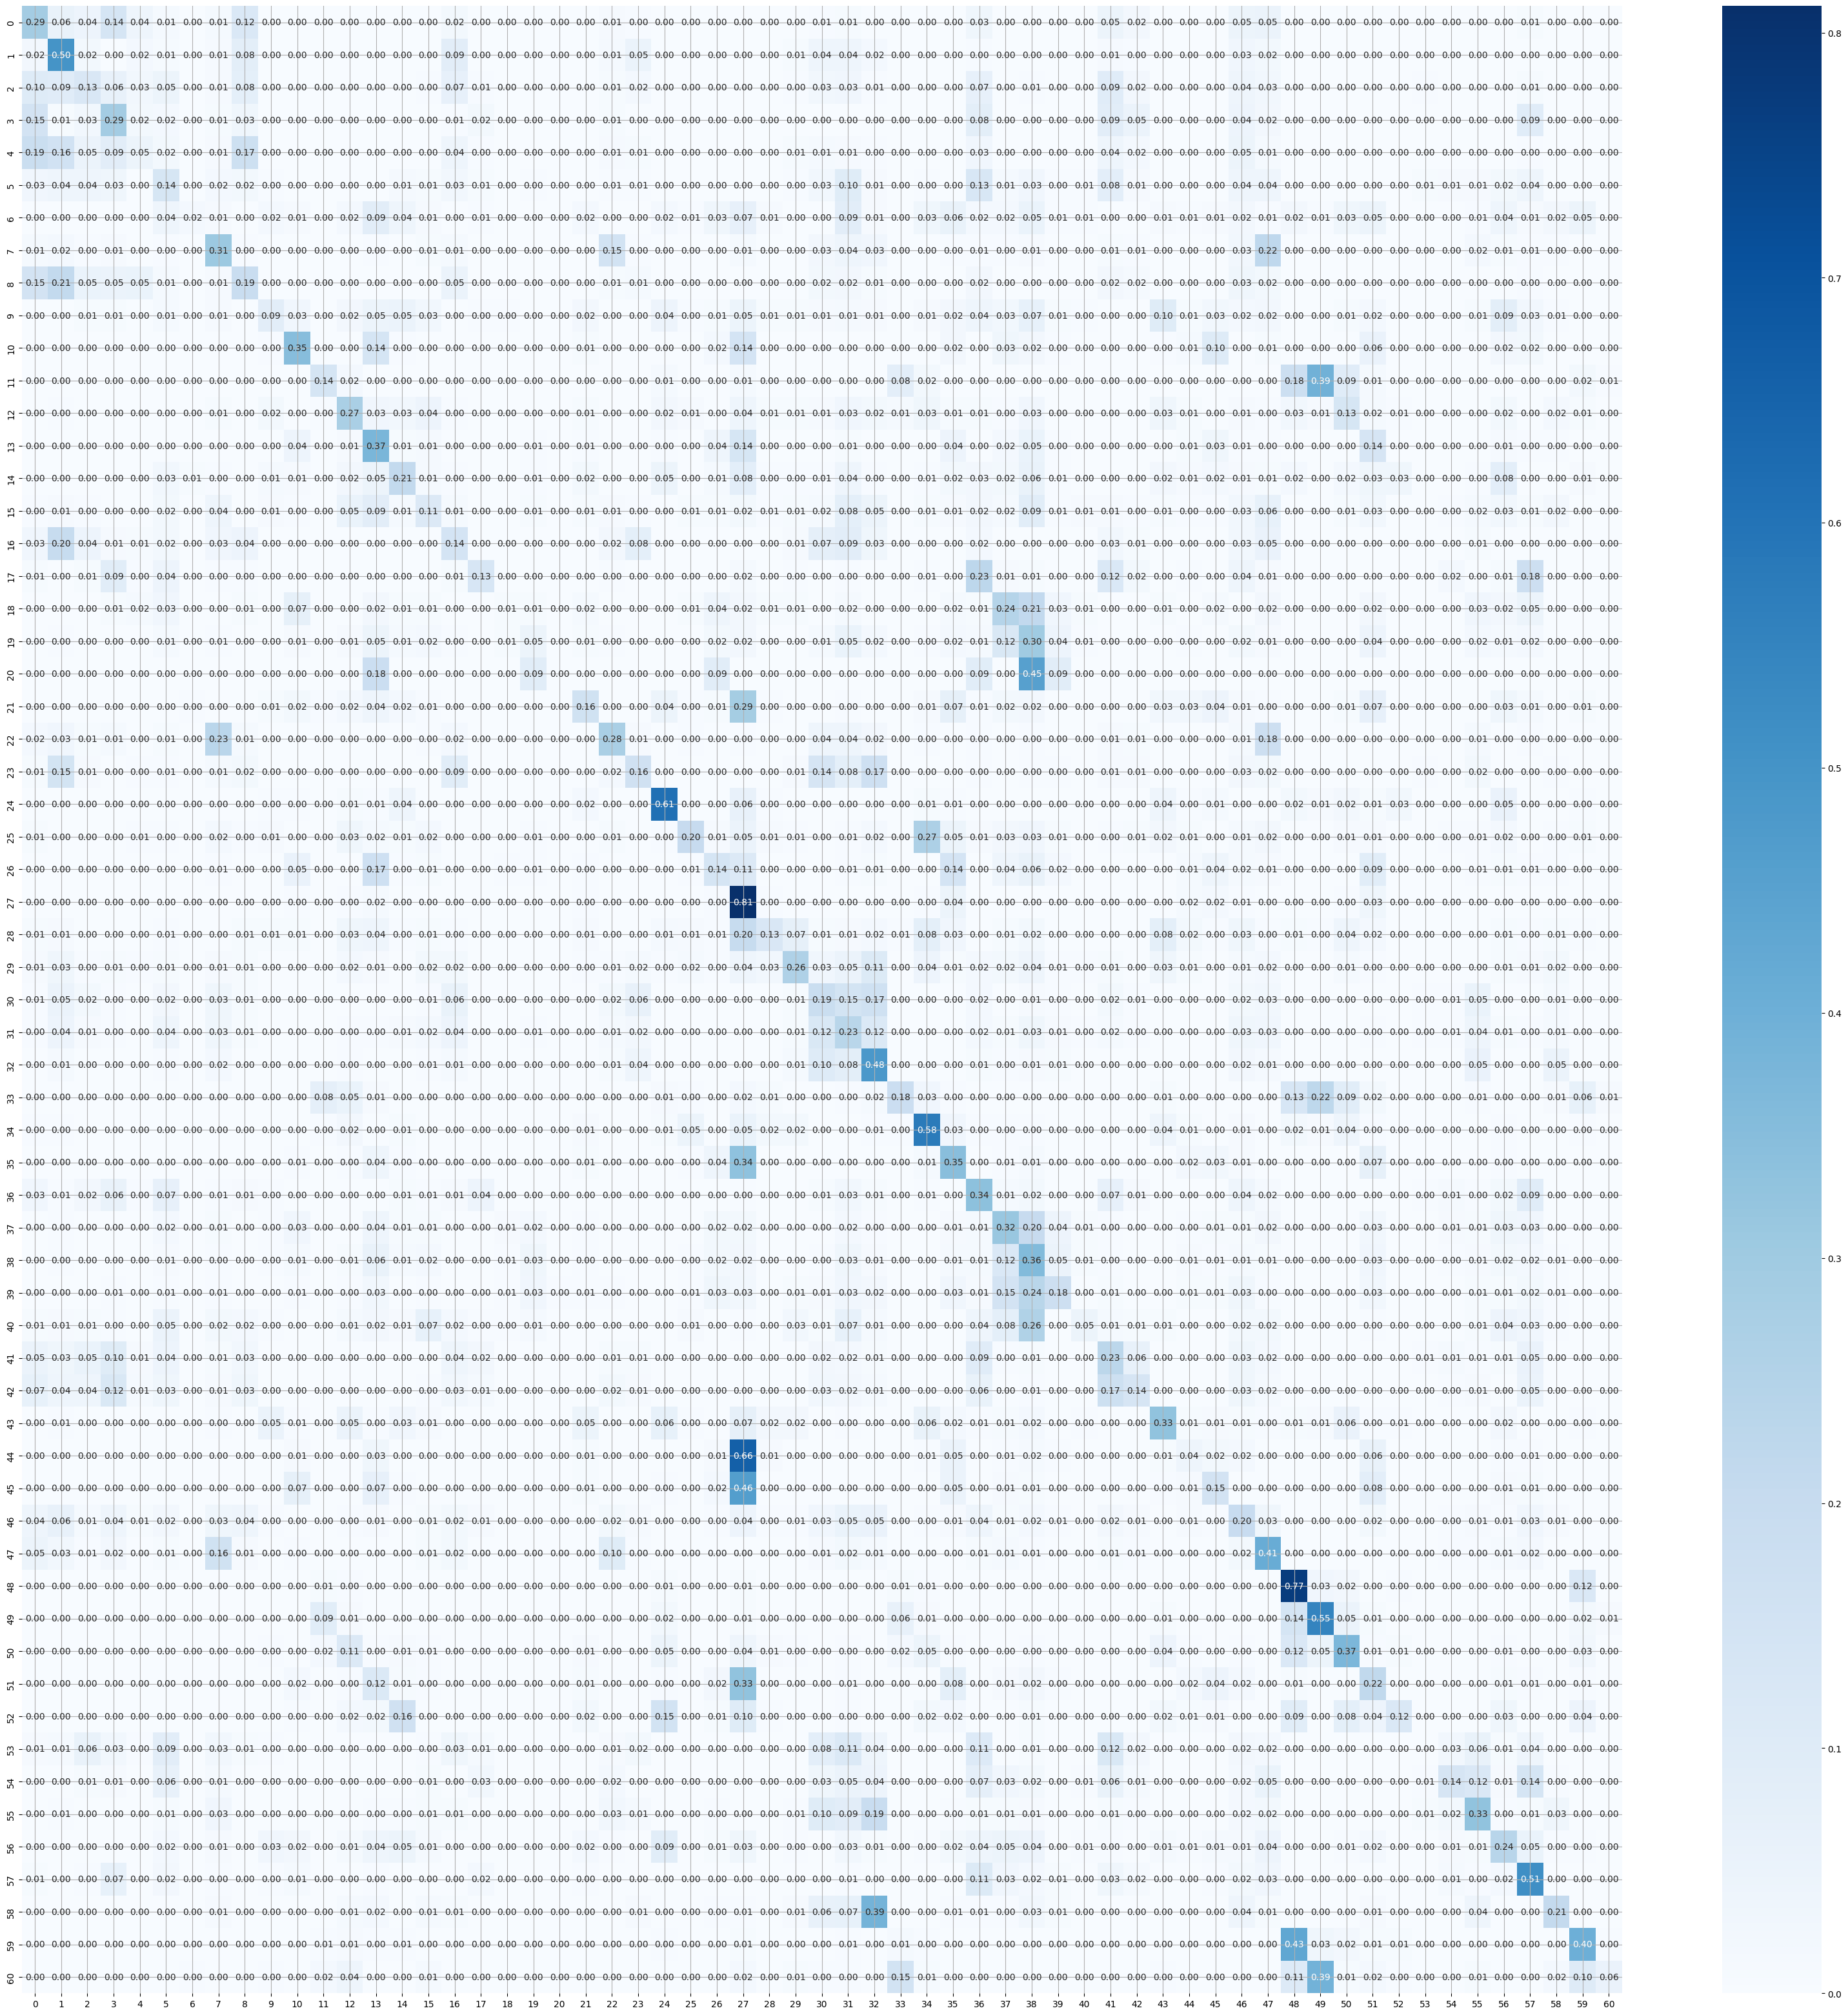

In [7]:
model_61 = load_model('./models/model_61.h5')

### evaluate the model and create a confusion matrix
X_test = np.array(mfcc_phn_test['mfcc'])
X_test = np.array([x[1:-1].split(',') for x in X_test], dtype=float)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_test = np.array(mfcc_phn_test['phoneme_num'])
y_test = np_utils.to_categorical(y_test)

y_pred = model_61.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(40, 40))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.grid(True)

# highlight the rows yello if they belong to the voiced phonemes
for i in range(61):
    if phn_num[i] in voiced:
        plt.gca().get_children()[i].set_color('yellow')
    elif phn_num[i] in unvoiced:
        plt.gca().get_children()[i].set_color('green')
    else:
        plt.gca().get_children()[i].set_color('blue')

# do the same for the columns
for i in range(61):
    if phn_num[i] in voiced:
        plt.gca().get_children()[i*61].set_color('yellow')
    elif phn_num[i] in unvoiced:
        plt.gca().get_children()[i*61].set_color('green')
    else:
        plt.gca().get_children()[i*61].set_color('blue')

plt.xticks(np.arange(61), phn_num.keys(), rotation=90)
plt.yticks(np.arange(61), phn_num.keys())
plt.xlabel('Predicted Phoneme')
plt.ylabel('True Phoneme')
plt.title('Confusion Matrix for 61 Phonemes')
plt.savefig('./confusion_matrix_61_sns.png')
plt.close()

In [54]:
# calculate accuracy for each phoneme
acc = []

for i in range(61):
    acc.append(cm[i][i])
acc = pd.DataFrame(acc, index=phn_num.keys(), columns=['accuracy'])
# add the number of samples for each phoneme
num_samples = []
for i in range(61):
    num_samples.append(sum(y_test == i))  
acc['num_samples'] = num_samples
# add the number of correct predictions for each phoneme
num_correct = []
for i in range(61):
    num_correct.append(cm[i][i] * num_samples[i])
acc['num_correct'] = num_correct

acc.to_csv('./acc_61.csv')

In [26]:
### create a RNN model to predict the phoneme type from the MFCCs
# the model has 2 hidden layers with 100 neurons each
# the activation function is relu
# the output layer has 3 neurons (the number of phoneme types)
# the activation function is softmax
# the loss function is categorical crossentropy
# the optimizer is adam
# the model is trained for 100 epochs
# import library for to_categorical
# convert the phoneme types to categorical data

mfcc_phn_train = pd.read_csv('./mfcc_phn_train.csv')
mfcc_phn_val = pd.read_csv('./mfcc_phn_val.csv')
mfcc_phn_test = pd.read_csv('./mfcc_phn_test.csv')

X_train = np.array(mfcc_phn_train['mfcc'])
X_train = np.array([x[1:-1].split(',') for x in X_train], dtype=float)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = np.array(mfcc_phn_train['label'])
y_train = np_utils.to_categorical(y_train)

X_val = np.array(mfcc_phn_val['mfcc'])
X_val = np.array([x[1:-1].split(',') for x in X_val], dtype=float)
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
y_val = np.array(mfcc_phn_val['label'])
y_val = np_utils.to_categorical(y_val)

# create LSTM model with 3 LSTM layers
model = Sequential()
model.add(LSTM(250, input_shape=(1, 13), return_sequences=True))
model.add(LSTM(250, return_sequences=True))
model.add(LSTM(250))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=100, validation_data=(X_val, y_val))

2023-05-14 10:34:56.972899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 10:34:56.975167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 10:34:56.977214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2023-05-14 10:34:57.576328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 10:34:57.578531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 10:34:57.580299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3768/3769 [============================>.] - ETA: 0s - loss: 0.4262 - accuracy: 0.8297

2023-05-14 10:36:04.415956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 10:36:04.417348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 10:36:04.418513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3769/3769 [==============================] - 71s 18ms/step - loss: 0.4262 - accuracy: 0.8297 - val_loss: 0.4135 - val_accuracy: 0.8356
Epoch 2/100
3769/3769 [==============================] - 62s 16ms/step - loss: 0.4098 - accuracy: 0.8368 - val_loss: 0.4034 - val_accuracy: 0.8423
Epoch 3/100
3769/3769 [==============================] - 62s 16ms/step - loss: 0.3996 - accuracy: 0.8414 - val_loss: 0.4095 - val_accuracy: 0.8392
Epoch 4/100
3769/3769 [==============================] - 62s 16ms/step - loss: 0.3939 - accuracy: 0.8434 - val_loss: 0.3965 - val_accuracy: 0.8437
Epoch 5/100
3769/3769 [==============================] - 62s 16ms/step - loss: 0.3907 - accuracy: 0.8445 - val_loss: 0.3978 - val_accuracy: 0.8449
Epoch 6/100
3769/3769 [==============================] - 62s 16ms/step - loss: 0.3863 - accuracy: 0.8462 - val_loss: 0.3894 - val_accuracy: 0.8453
Epoch 7/100
3769/3769 [==============================] - 62s 16ms/step - loss: 0.3844 - accuracy: 0.8475 - val_loss: 0.3911 - val_

In [27]:
# save the model
model.save('./model4.h5')

In [28]:
### a function for predicting the segmentation based on MFCCs
# the function takes in the path to a folder
# the function reads in the test file and the phoneme file
# the function predicts the voiced, unvoiced, silence segmentations from the MFCCs
# the function returns the accuracy, the original segmentation, and the predicted segmentation

def predict_segmentation(testpath):
    testfile = testpath + '.wav'
    phnfile = testpath + '.phn'
    
    # read in the test file
    seq, Fs = librosa.load(testfile, sr=None)
    mfcc_test = librosa.feature.mfcc(y=seq, sr=Fs, n_mfcc=13).T
    
    y_pred = model.predict(mfcc_test.reshape((mfcc_test.shape[0], 1, mfcc_test.shape[1])))
    y_pred = np.argmax(y_pred, axis=1)
    
    framelen = len(seq) // len(y_pred)
    
    # read in the phoneme file
    with open(phnfile, 'r') as f:
        phn = f.readlines()
        
    seg_original = np.zeros_like(seq)
    for i in range(len(phn)):
        start, end, phoneme = phn[i].split()
        start = int(start)
        end = int(end)
        if phoneme in voiced:
            seg_original[start:end] = 0
        elif phoneme in unvoiced:
            seg_original[start:end] = 1
        else:
            seg_original[start:end] = 2
    
    seg_predicted = np.zeros_like(seq)
    for i in range(len(y_pred)):
        if y_pred[i] == 0:
            seg_predicted[i*framelen:(i+1)*framelen] = 0
        elif y_pred[i] == 1:
            seg_predicted[i*framelen:(i+1)*framelen] = 1
        else:
            seg_predicted[i*framelen:(i+1)*framelen] = 2
    
    accuracy = np.sum(seg_original == seg_predicted) / len(seg_original)
    
     
    # plot the audio file and the phoneme segmentation
    plt.figure(figsize=(20,10))
    plt.subplot(2,1,1)
    plt.plot(seq)
    plt.title('Original Segmentation')
    # plot the segmentation
    for i in range(len(phn)):
        start, end, phoneme = phn[i].split()
        start = int(start)
        end = int(end)
        if phoneme in voiced:
            color = 'yellow'
        elif phoneme in unvoiced:
            color = 'green'
        else:
            color = 'blue'
        plt.axvspan(start, end, color=color, alpha=0.5)
    
    plt.subplot(2,1,2)
    plt.plot(seq)
    plt.title('Predicted Segmentation')
    # plot the segmentation
    for i in range(len(y_pred)):
        if y_pred[i] == 0:
            plt.axvspan(i*framelen, (i+1)*framelen, color='yellow', alpha=0.5)
        elif y_pred[i] == 1:
            plt.axvspan(i*framelen, (i+1)*framelen, color='green', alpha=0.5)
        else:
            plt.axvspan(i*framelen, (i+1)*framelen, color='blue', alpha=0.5)

    plt.suptitle('{:s}       Accuracy: {:.2f}%'.format(testpath, accuracy*100))
    plt.savefig('./results2/%s.png'%testpath.replace('/', '_').replace('.',''))
    plt.close()
    
    return accuracy, seg_original, seg_predicted

In [32]:
hist_acc = []
seg_original = []
seg_predicted = []
print(test)
for item in test:
    files = os.listdir(item)
    for file in files:
        if file.endswith('.wav'):
            try: 
                data, sego, segp = predict_segmentation(item + '/' + file[:-4])
                seg_original.extend(sego)
                seg_predicted.extend(segp)
                hist_acc.append(data)
            except: 
                print('exception occured')
                pass

seg_original = np.array(seg_original)
seg_predicted = np.array(seg_predicted)
hist_acc = np.array(hist_acc)

np.savetxt('./seg_original2.csv', seg_original, delimiter=',')
np.savetxt('./seg_predicted2.csv', seg_predicted, delimiter=',')
np.savetxt('./hist_acc2.csv', hist_acc, delimiter=',')

['./timit_wav/test/dr1/msjs1', './timit_wav/test/dr1/mjsw0', './timit_wav/test/dr1/felc0', './timit_wav/test/dr1/mdab0', './timit_wav/test/dr1/mwbt0', './timit_wav/test/dr1/mstk0', './timit_wav/test/dr1/mreb0', './timit_wav/test/dr1/faks0', './timit_wav/test/dr1/fdac1', './timit_wav/test/dr1/fjem0', './timit_wav/test/dr1/mrjo0', './timit_wav/test/dr2/mtas1', './timit_wav/test/dr2/mrgg0', './timit_wav/test/dr2/mpdf0', './timit_wav/test/dr2/mabw0', './timit_wav/test/dr2/mdbb0', './timit_wav/test/dr2/mccs0', './timit_wav/test/dr2/fjwb0', './timit_wav/test/dr2/mbjk0', './timit_wav/test/dr2/fram1', './timit_wav/test/dr2/mcem0', './timit_wav/test/dr2/fjas0', './timit_wav/test/dr2/mgwt0', './timit_wav/test/dr2/mdld0', './timit_wav/test/dr2/fcmr0', './timit_wav/test/dr2/fjre0', './timit_wav/test/dr2/mwvw0', './timit_wav/test/dr2/mmdm2', './timit_wav/test/dr2/fslb1', './timit_wav/test/dr2/mjar0', './timit_wav/test/dr2/mrcz0', './timit_wav/test/dr2/mmdb1', './timit_wav/test/dr2/fpas0', './timit_

2023-05-14 12:19:59.231706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-14 12:19:59.233273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-14 12:19:59.234502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 0s 4ms/step
exception occured
2/2 [==============================] - 0s 5ms/step
exception occured
4/4 [==============================] - 0s 4ms/step
exception occured
4/4 [==============================] - 0s 4ms/step
exception occured
5/5 [==============================] - 0s 4ms/step
exception occured
4/4 [==============================] - 0s 3ms/step
exception occured
3/3 [==============================] - 0s 4ms/step
exception occured
4/4 [==============================] - 0s 4ms/step
exception occured
4/4 [==============================] - 0s 4ms/step
exception occured
5/5 [==============================] - 0s 3ms/step
exception occured
4/4 [==============================] - 0s 4ms/step
exception occured
3/3 [==============================] - 0s 4ms/step
exception occured
4/4 [==============================] - 0s 4ms/step
exception occured
3/3 [==============================] - 0s 3ms/step
exception occured
3/3 [=============================

In [35]:
hist_acc = sorted(hist_acc)
print(np.average(hist_acc))
print(np.median(hist_acc))
print(hist_acc[0], hist_acc[-1])


0.8042591751534434
0.8062677663615487
0.48917683119909816 0.9719285964298215


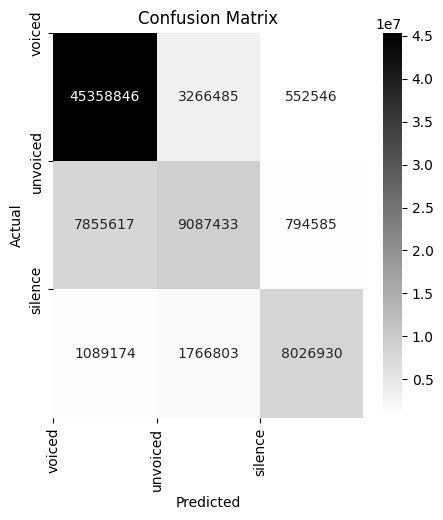

In [33]:
### creating a dataframe from history
import seaborn as sns

pred_y = np.loadtxt('./seg_predicted2.csv', delimiter=',')
orig_y = np.loadtxt('./seg_original2.csv', delimiter=',')

# create a confusion matrix

cm = confusion_matrix(orig_y, pred_y)
plt.figure(figsize=(5,5))
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True, fmt='d', cmap='binary')

plt.xticks(np.arange(3), ['voiced', 'unvoiced', 'silence'], rotation=90)
plt.yticks(np.arange(3), ['voiced', 'unvoiced', 'silence'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()